<h1 style="font-family:verdana;"> <center>🔨 Shipping Duration Prediction ⚙️</center> </h1>
<p><center style="color:#159364; font-family:cursive;"><cite>Modelling Delivery Estimation Model with Hyperparameter Tuning
</cite></center></p>

<div style="text-align:center"><img src="../figure/shipping-process.webp" /></div>

---

**Model Description:** 

Delivery Estimation Model is a model that can predict the duration for an order after being approved by seller to reach the customer. As an assumption, this model assume that the order will take place between 1 seller and 1 customer (1-1 relationship). This model later on can be used as reference for seller and logistic party to measure their shipping performance, and if accurately enough, can be used to estimate order delivery duration for customer 

**Task:** Regression

**Metric:** [Root Mean Square Log Error (RMSLE)](https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle)

**Goals :** 

1. Feature Selection for each seperate model
2. Modelling few baseline model to see the best model for current case
3. Tune the best model

## 📙 Import Library

In [56]:
# Basic 
import sys
import json

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Profiling process
from tqdm import tqdm

# Reporting result
from IPython.display import display

import pickle

# Math
import numpy as np
import scipy as sp
import pandas as pd
from numpy import log10, log

# Statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn import metrics
from catboost import CatBoostRegressor, Pool

# Learning Helper | Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression, PoissonRegressor, RANSACRegressor

# CLustering
from sklearn.cluster import KMeans

# Dimension reductionality
from sklearn.decomposition import PCA

In [57]:
# Progress apply for pandas
tqdm.pandas()

# Seaborn color palette
sns.set_palette('husl')

# Inline matplotlib
%matplotlib inline

plt.style.use('default')

# === Color pallete ===
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0),  # Yellow
    (255, 255, 255), # White
    (0, 0, 0), # Black
]

light_palette = np.array(raw_light_palette)/255

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Larger scale for plots in notebooks
sns.set_context('notebook')

In [58]:
# Calculating multicollinearity
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

# Saving model 
def save_model(model, name="model"):
    pickle.dump(model, open(f"../bin/{name}", "wb"))
    
# Load Model
def load_model(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

In [59]:
def evaluate_model(true, predicted):  
    rmsle = metrics.mean_squared_log_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2 = metrics.r2_score(true, predicted)
    print('RMSLE:',rmsle)
    print('RMSE:', rmse)
    print("R2:", r2)
    print('__________________________________')
    return rmsle, rmse, r2 

## 🎒 Load Data

In [5]:
# === Load data ===
## EDIT THIS CODE
# =====================
filename = "../data/processed/dataset-supervised-processed.pkl"
# =====================

target = "wd_actual_delivery_interval"

df = pd.read_pickle(filename)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90183 entries, 0 to 95126
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   total_unique_item                90183 non-null  int64  
 1   product_volume_cm3_per_item      90183 non-null  float64
 2   product_weight_g_per_item        90183 non-null  float64
 3   order_day_of_week                90183 non-null  int64  
 4   order_day_of_month               90183 non-null  int64  
 5   order_quarter                    90183 non-null  float64
 6   order_is_weekend                 90183 non-null  bool   
 7   order_hour                       90183 non-null  int64  
 8   order_daytime                    90183 non-null  object 
 9   order_approved_day_of_week       90183 non-null  float64
 10  order_approved_day_of_month      90183 non-null  float64
 11  order_approved_quarter           90183 non-null  float64
 12  order_approved_is_

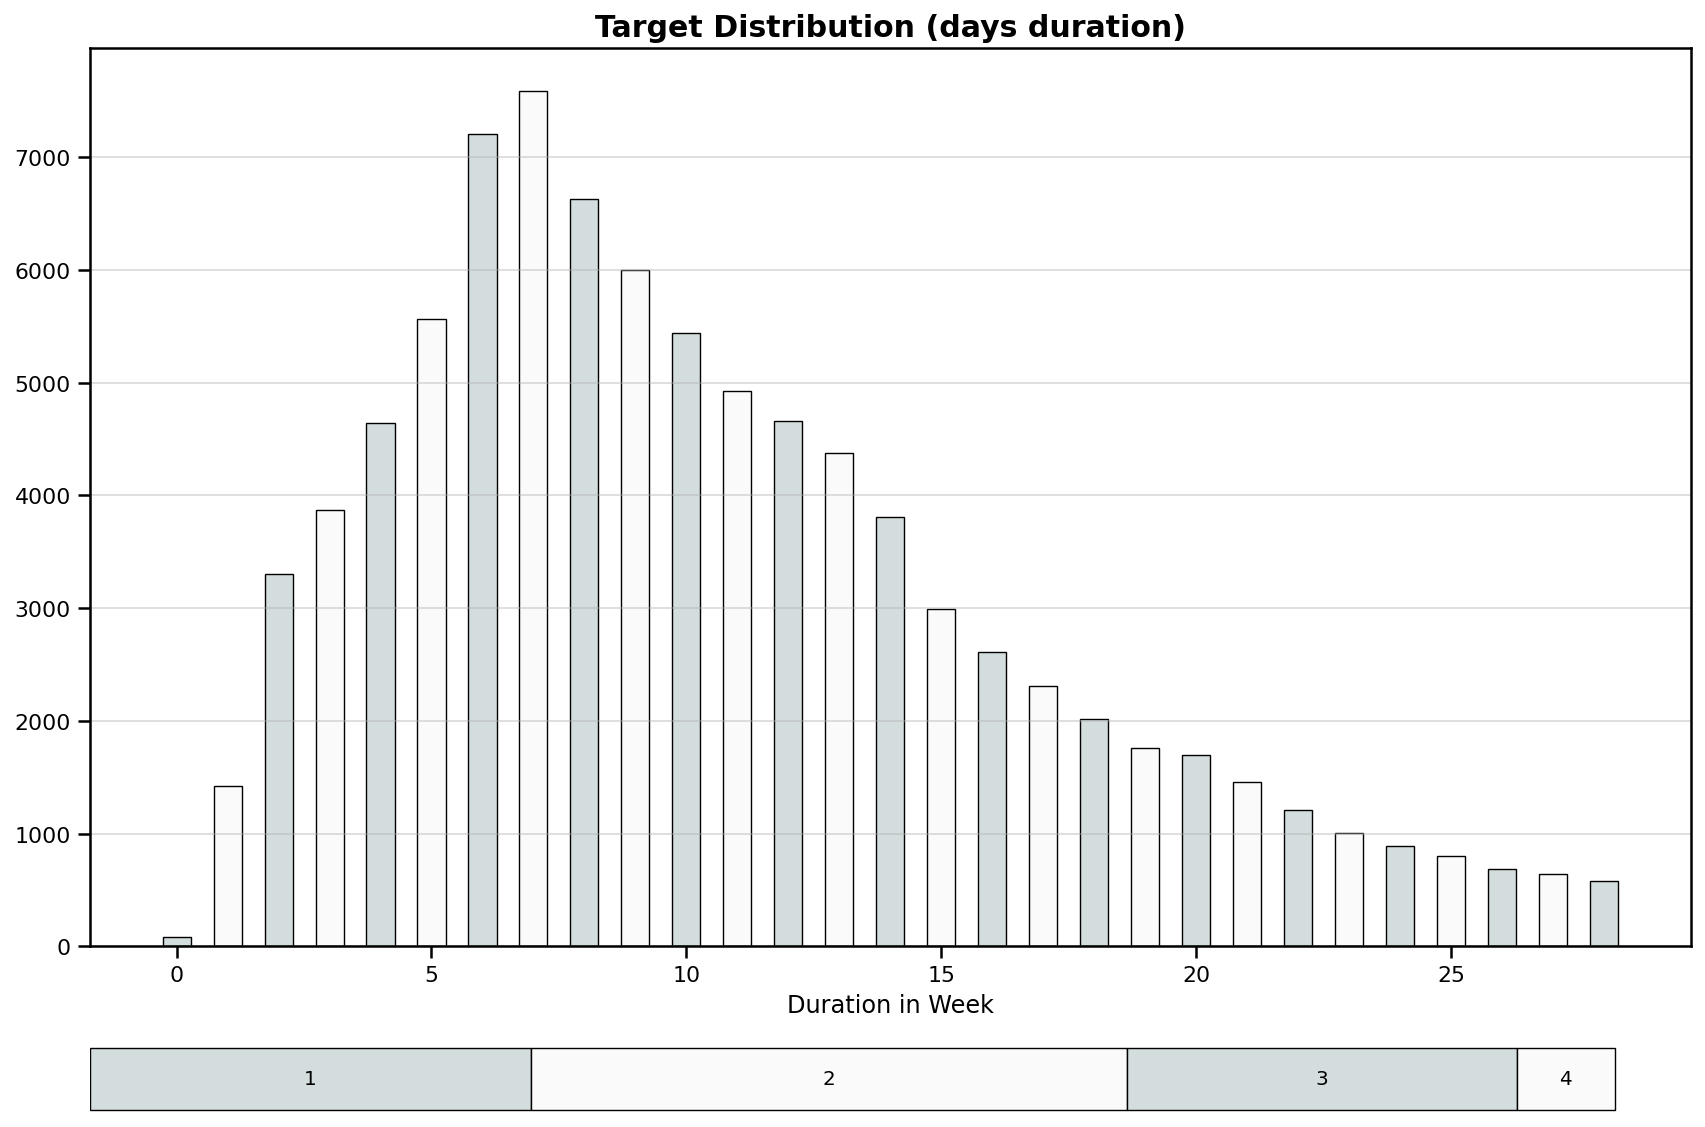

In [6]:
# === Show Distribution === 
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(7, 4)
ax = fig.add_subplot(gs[:-1,:])
ax2 = fig.add_subplot(gs[-1,:])
ax2.axis('off')

target_cnt = df[target].value_counts().sort_index()
target_cum = target_cnt.cumsum()
ax.bar(target_cnt.index, target_cnt, color=['#d4dddd' if i%2==0 else '#fafafa' for i in range(29)],
       width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

weekly_cnt = pd.Series([len(df[target].loc[df[target] < 7].values), 
           len(df[target].loc[(df[target] >= 7) & (df[target] < 13)].values),
           len(df[target].loc[(df[target] >= 13) & (df[target] < 22)].values),
           len(df[target].loc[df[target] >= 22].values)
          ])

weekly_cum = weekly_cnt.cumsum()

for i in range(4):
    ax2.barh([0], [weekly_cnt[i]], left=[weekly_cum[i] - weekly_cnt[i]], height=0.2, 
            edgecolor='black', linewidth=0.7, color='#d4dddd' if i%2==0 else '#fafafa'
            )
    ax2.annotate(i+1, xy=(weekly_cum[i]-weekly_cnt[i]/2, 0), 
                 va='center', ha='center', fontsize=10)

ax.set_title('Target Distribution (days duration)', weight='bold', fontsize=15)
ax.grid(axis='y', linestyle='-', alpha=0.4)

ax.set_xlabel("Duration in Week")

fig.tight_layout()
plt.show()

## $Baseline$

In [7]:
print("=== Baseline for Evaluation (current usage) ===")
rmsle, rmse, r2 = evaluate_model(df['wd_actual_delivery_interval'], df['wd_estimated_delivery_interval'])
# === Adding to Model Combine ===
# === Setting up the result dataframe (from baseline)=== 
results_df = pd.DataFrame(data=[["Baseline (Naive)", rmsle, rmse, r2]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])

# results_df = results_df.append(results_df_2, ignore_index=True)
results_df.style.highlight_min(subset=['RMSLE', 'RMSE'],color='lightgreen', axis = 0).highlight_max(subset=['R2'], color = 'lightgreen', axis = 0)

=== Baseline for Evaluation (current usage) ===
RMSLE: 0.9402129691805824
RMSE: 15.229216797873669
R2: -5.3478983950032175
__________________________________


,Model,RMSLE,RMSE,R2
0,Baseline (Naive),0.940213,15.229217,-5.347898


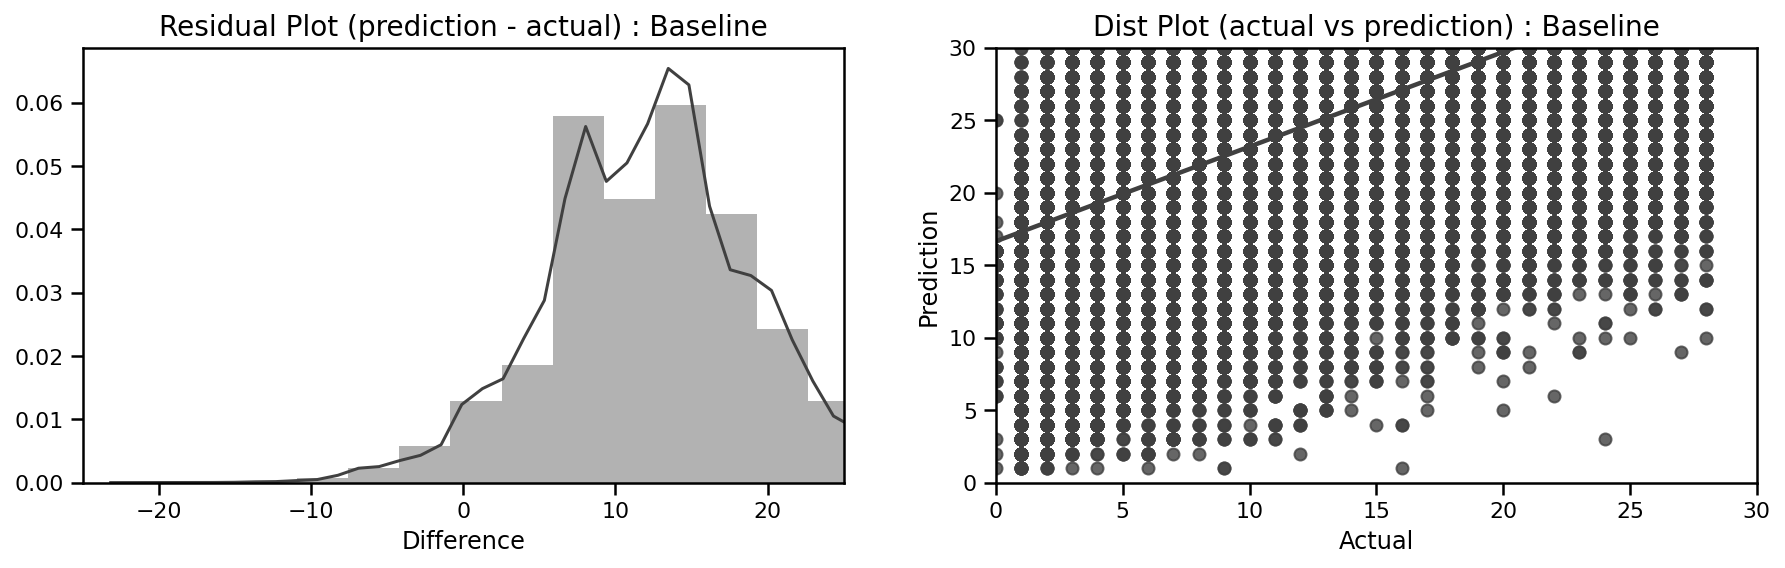

In [9]:
def plot(y_test, pred, model, color='0.25'):    
    plt.figure(figsize=(15,4))

    score_df = pd.DataFrame({
        'actual': y_test,
        'prediction' : pred
    })

    plt.subplot(1,2,1)
    plt.title(f"Residual Plot (prediction - actual) : {model}", fontsize = 14)
    a = sns.distplot(score_df['prediction'] - score_df["actual"], color=color)
    a.set_xlabel("Difference",fontsize=12)
    a.set_xlim(-25, 25)
    plt.plot()

    plt.subplot(1,2,2)
    plt.title(f"Dist Plot (actual vs prediction) : {model}", fontsize = 14)
    g = sns.regplot('actual', 'prediction', data=score_df, color=color)
    g.set_xlabel("Actual",fontsize=12)
    g.set_ylabel("Prediction",fontsize=12)
    g.set_xlim(0,30)
    g.set_ylim(0,30)
    plt.plot()

    plt.show()
    
plot(df['wd_actual_delivery_interval'].values, df['wd_estimated_delivery_interval'].values,"Baseline")

## $Linear\ Model$
---

<p><center style="color:#159364; font-family:cursive;"><cite>Linear Regression in a nutshell
</cite></center></p>
<div style="text-align:center"><img src="../figure/lin-reg.jpg" /></div>

> Linear regression is been studied at great length, and there is a lot of literature on how your data must be structured to make best use of the model.

> As such, there is a lot of sophistication when talking about these requirements and expectations which can be intimidating. In practice, you can uses these rules more as rules of thumb when using Ordinary Least Squares Regression, the most common implementation of linear regression.

- **Linear Assumption.** Linear regression assumes that the relationship between your input and output is linear. It does not support anything else. This may be obvious, but it is good to remember when you have a lot of attributes. You may need to transform data to make the relationship linear (e.g. log transform for an exponential relationship).
- **Remove Noise.** Linear regression assumes that your input and output variables are not noisy. Consider using data cleaning operations that let you better expose and clarify the signal in your data. This is most important for the output variable and you want to remove outliers in the output variable (y) if possible.
- **Remove Collinearity.** Linear regression will over-fit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.
- **Gaussian Distributions.** Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on you variables to make their distribution more Gaussian looking.
- **Rescale Inputs:** Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

### ✀ Feature Selection & Data Preparation

---
**Steps :** 
1. Use Correlation For Numerical columns -> Filter columns with really low and really high correlation with label
2. Use ViF to filter out multicollinearity columns

In [10]:
used_cols = [
    'log_aov',
    'log_shipping_cost',
    'wd_pickup_limit_interval',
    'log_package_weight_g',
    'product_weight_g_per_item',
    'cbrt_original_distance',
    'is_same_area',
]

target = 'wd_actual_delivery_interval'
detector = 'wd_estimated_delivery_interval'

,wd_actual_delivery_interval
wd_actual_delivery_interval,1.000000
log_shipping_cost,0.211363
cbrt_original_distance,0.203099
wd_pickup_limit_interval,0.126716
log_aov,0.094688
log_package_weight_g,0.086532
product_weight_g_per_item,0.078520
is_same_area,-0.155489


<AxesSubplot:>

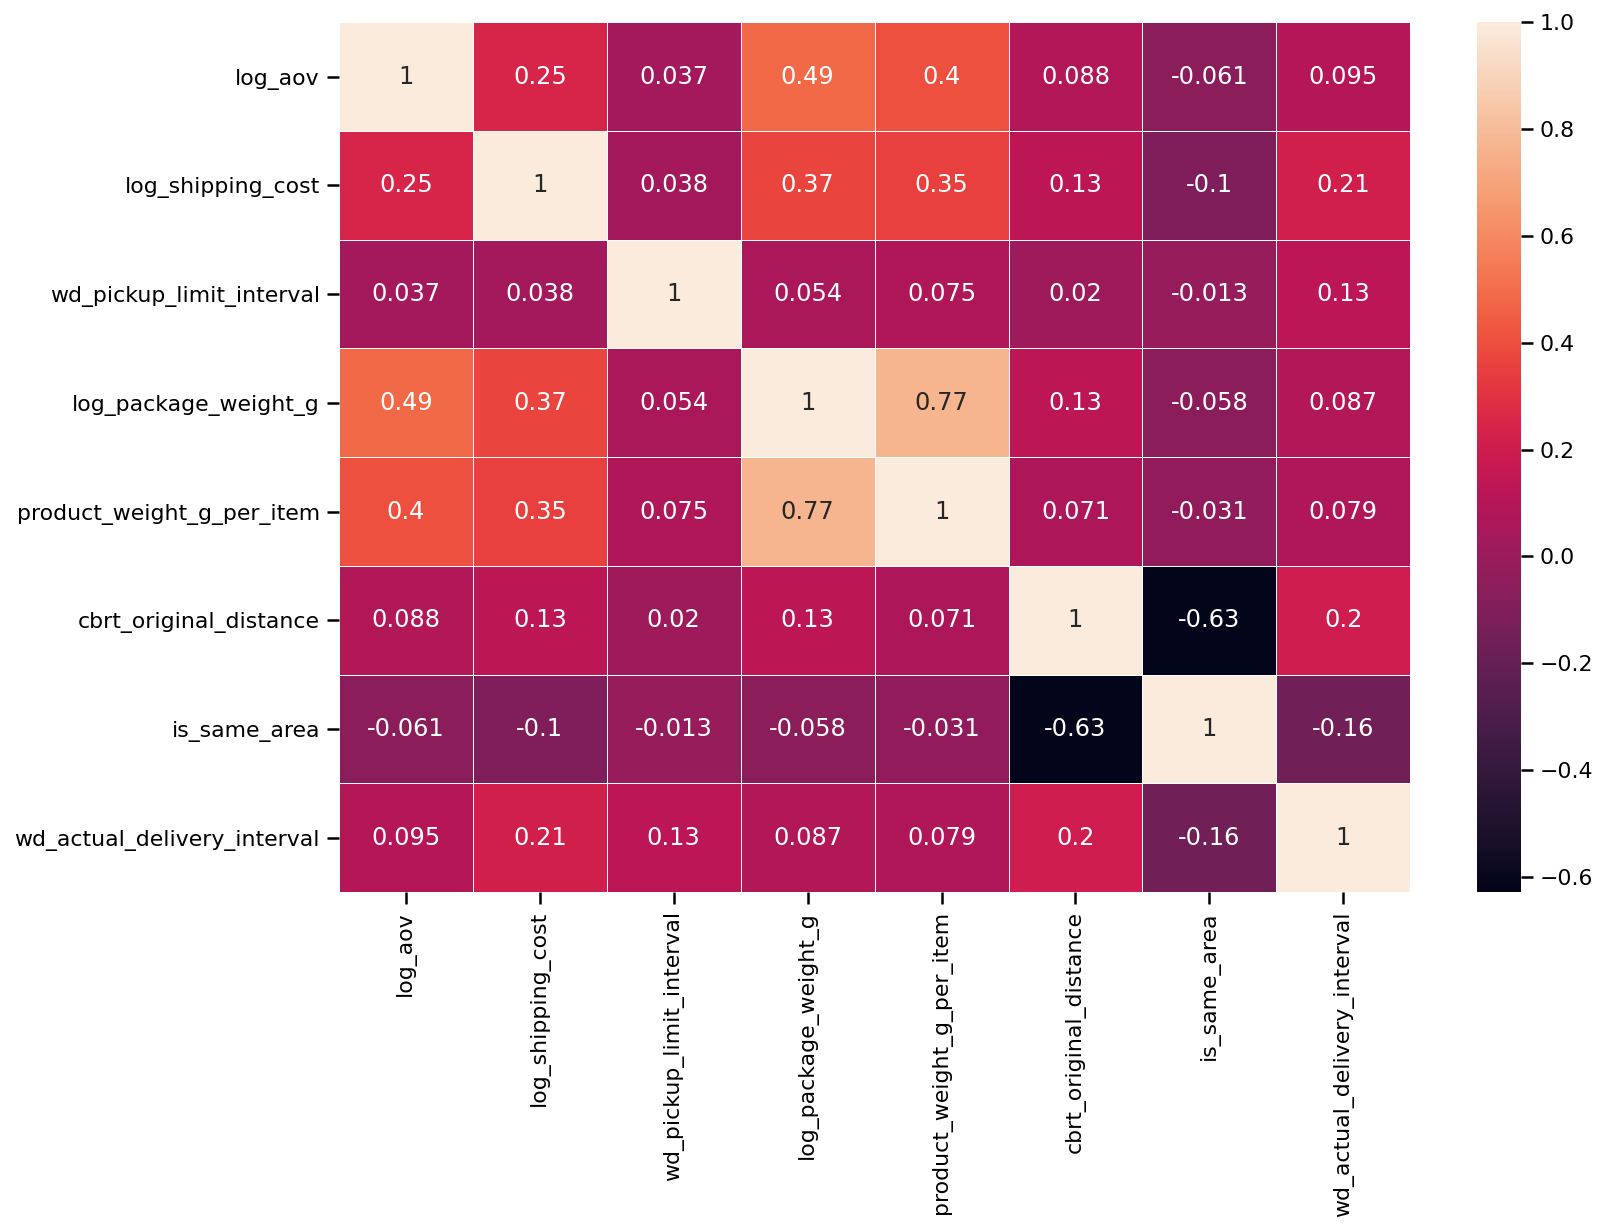

In [11]:
# === Defining the detector cols ===
df['is_same_area'] = df['is_same_area'].astype('int')
to_drop = [
    "wd_estimated_delivery_interval"
]

corr = df[used_cols + [target, detector]].drop(to_drop, axis = 1).corr()
lowerlimit = 0 # limit the correlation
upperlimit = 0.8
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs()[target] < lowerlimit) & ~(corr.mask(np.eye(len(corr), dtype=bool)).abs()[target] > upperlimit) &  ~(corr.mask(np.eye(len(corr), dtype=bool)).abs()[target].isna())
m[target] = True
limited = corr.loc[m]
corr_cols = [col for col in m.index if m[col]]
display(limited[target].to_frame().sort_values(by=target, ascending=False).style.background_gradient())


# === Multi collinearity ===
drop_cols = ["log_total_price", "log_aov"]

# vif = calc_vif(df[corr_cols].drop(drop_cols + [target], axis=1))
# vif.sort_values(by="VIF", ascending=False).style.background_gradient()

plt.figure(figsize=(12,8))
sns.heatmap(df[corr_cols].corr(), linewidth=.5,annot=True)

### 📈 Build Model

In [12]:
numerical = ["log_aov", "log_shipping_cost", "wd_pickup_limit_interval", "log_package_weight_g", "product_weight_g_per_item", "cbrt_original_distance"]
categorical = ["is_same_area"]

linear_df = df.copy()
linear_df = linear_df[numerical+categorical+[target]]

In [13]:
X = linear_df.drop([target], axis = 1)
y = linear_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72146 entries, 32702 to 16670
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   log_aov                    72146 non-null  float64
 1   log_shipping_cost          72146 non-null  float64
 2   wd_pickup_limit_interval   72146 non-null  int64  
 3   log_package_weight_g       72146 non-null  float64
 4   product_weight_g_per_item  72146 non-null  float64
 5   cbrt_original_distance     72146 non-null  float64
 6   is_same_area               72146 non-null  int32  
dtypes: float64(5), int32(1), int64(1)
memory usage: 4.1 MB


In [15]:
# === Scaling ===
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# Encode
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    new_cols = []
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        for col in dummies.columns:
            new_cols.append(col)
    return df, new_cols
# === One Hot Encoding ===
X_train, _ = one_hot(X_train, categorical)
X_test, _ = one_hot(X_test, categorical)
X_train = X_train.drop(categorical, axis = 1)
X_test = X_test.drop(categorical, axis = 1)


In [16]:
lin_reg =  LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [17]:
poisson_reg =  PoissonRegressor(alpha=1e-12, max_iter=1000)
poisson_reg.fit(X_train,y_train)

PoissonRegressor(alpha=1e-12, max_iter=1000)

### 🔍 Evaluation
---
> - **Root Mean Squared Log Error** (RMSLE) :
$$\sqrt{\frac{1}{N} \sum_{i=0}^{N}(\log(y_i + 1) - \log({\hat{y}}_i + 1))^2}$$

> - **Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:
$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

> All of these are **loss functions**, because we want to minimize them.

In [18]:
print("=== Evaluating Linear Regression Model ===")

pred = lin_reg.predict(X_test)
pred = list(map(lambda val : max(0,val), pred)) # ReLU Function
rmsle, rmse, r2 = evaluate_model(y_test, pred)

# === Adding to Model Combine ===
# === Setting up the result dataframe (from baseline)=== 
results_lin_df = pd.DataFrame(data=[["Linear Regression", rmsle, rmse, r2]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])
results_df = results_df.append(results_lin_df, ignore_index=True)

=== Evaluating Linear Regression Model ===
RMSLE: 0.3206103382640925
RMSE: 5.720783088889173
R2: 0.1019131910348805
__________________________________


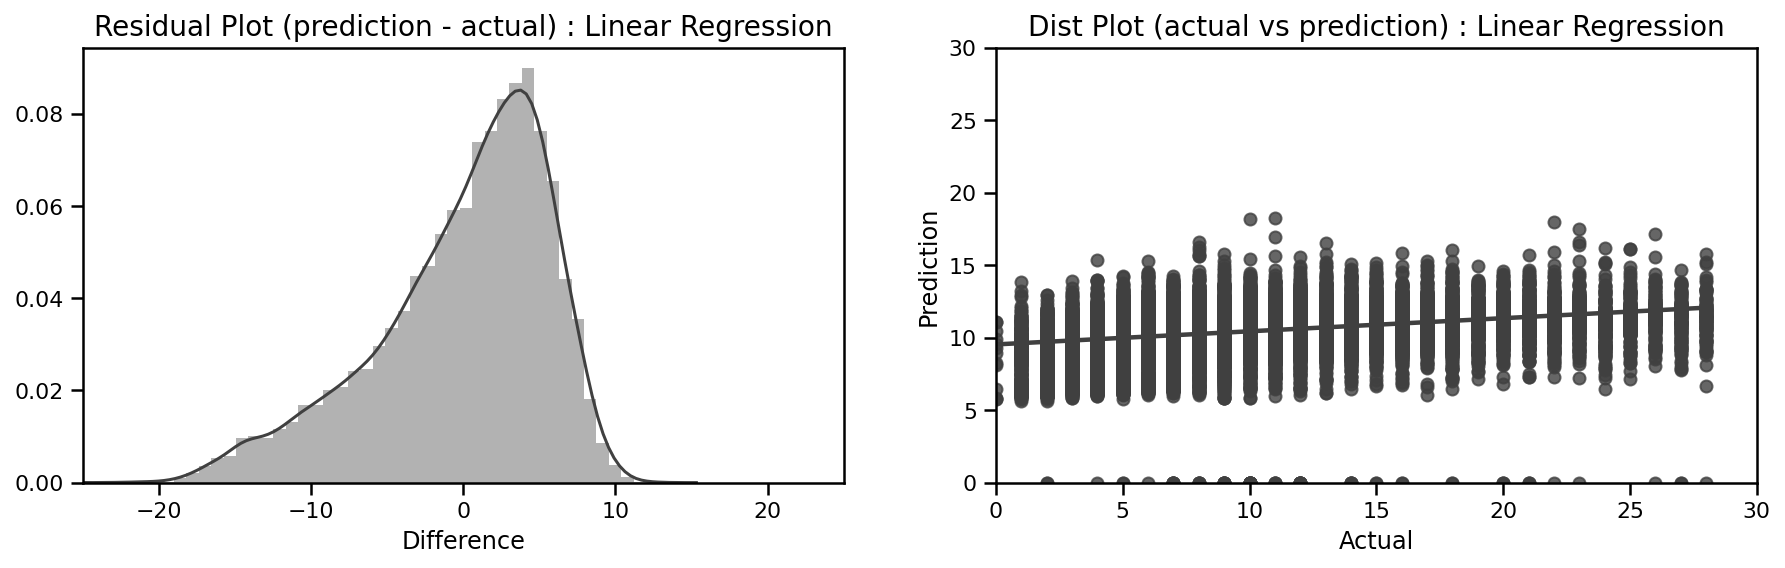

In [19]:
plot(y_test, pred,"Linear Regression")

In [20]:
print("=== Evaluating Poisson Regression Model ===")
pred = poisson_reg.predict(X_test)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

# === Adding to Model Combine ===
# === Setting up the result dataframe (from baseline)=== 
results_poisson_df = pd.DataFrame(data=[["Poisson Regression", rmsle, rmse, r2]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])
results_df = results_df.append(results_poisson_df, ignore_index=True)

=== Evaluating Poisson Regression Model ===
RMSLE: 0.30550252685452345
RMSE: 5.721653454788607
R2: 0.10163989852135369
__________________________________


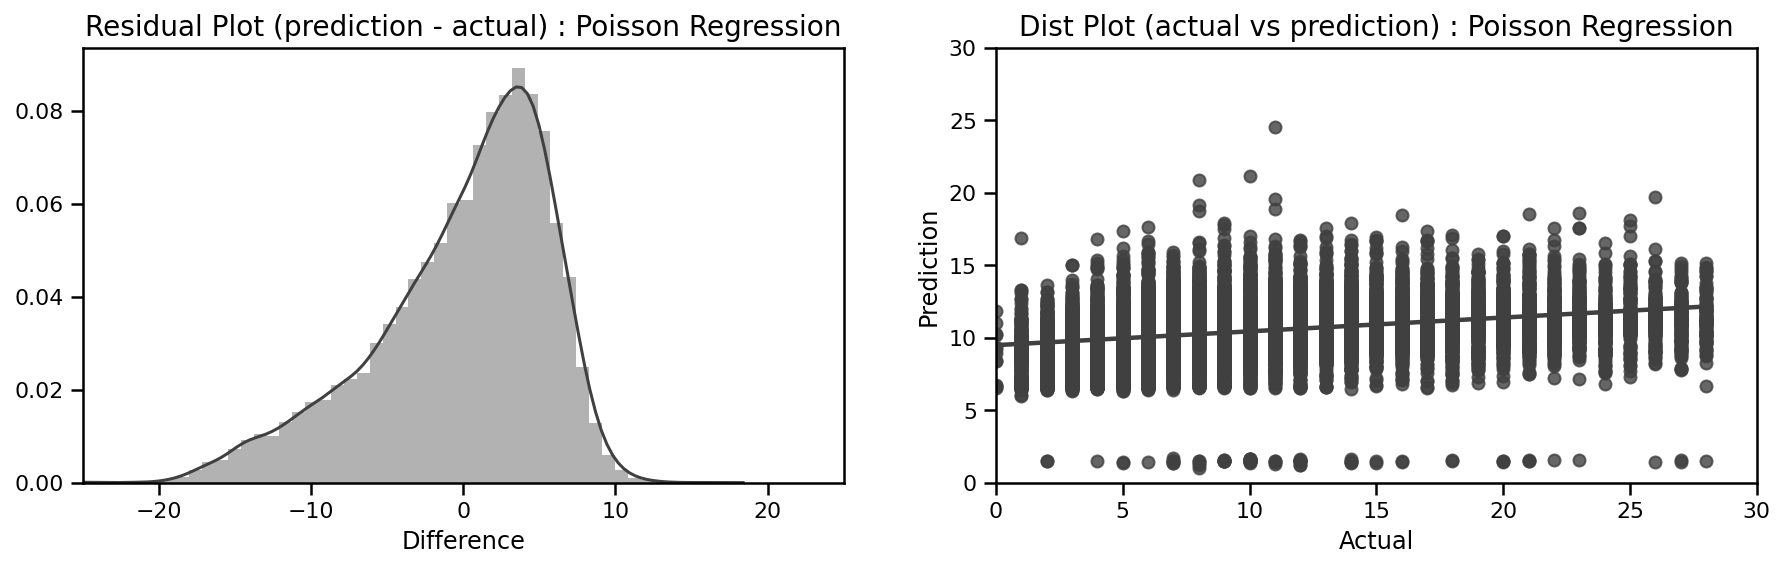

In [21]:
plot(y_test, pred,"Poisson Regression")

## $Support\ Vector\ Machine$
---
<p><center style="color:#159364; font-family:cursive;"><cite>SVM in a nutshell
</cite></center></p>
<div style="text-align:center"><img src="../figure/svm.png" /></div>

SVM algorithm is capable for regression task and outlier detection. **SVM regression** aims to fit as many datapoints as possible *between* the margins while limiting margin violations (datapoints off the "working day duration"). Related Scikit-Learn functions are: [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), and [linearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html).

### ✀ Feature Selection & Data Preparation

In [22]:
numerical = ["log_aov", "log_shipping_cost", "wd_pickup_limit_interval", "log_package_weight_g", "product_weight_g_per_item", "cbrt_original_distance"]
categorical = ["is_same_area"]

svm_df = df.copy()
svm_df = svm_df[numerical+categorical+[target]]

In [23]:
X = svm_df.drop([target], axis = 1)
y = svm_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

In [24]:
# === Scaling ===
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# Encode
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    new_cols = []
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        for col in dummies.columns:
            new_cols.append(col)
    return df, new_cols
# === One Hot Encoding ===
X_train, _ = one_hot(X_train, categorical)
X_test, _ = one_hot(X_test, categorical)
X_train = X_train.drop(categorical, axis = 1)
X_test = X_test.drop(categorical, axis = 1)

### 📈 Build Model

In [27]:
from sklearn.svm import SVR

# === Implementation (uncomment to re-train) ===
# svm = SVR(kernel = 'rbf')
# svm.fit(X_train[:10000], y_train[:10000])

# Load Model
with open("../bin/svm-regressor.model", 'rb') as f:
    svm = pickle.load(f)

In [205]:
# save_model(svm, "svm-regressor.model")

### 🔍 Evaluation
---
> - **Root Mean Squared Log Error** (RMSLE) :
$$\sqrt{\frac{1}{N} \sum_{i=0}^{N}(\log(y_i + 1) - \log({\hat{y}}_i + 1))^2}$$

> - **Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:
$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

> All of these are **loss functions**, because we want to minimize them.

In [28]:
print("=== Evaluating Support Vector Regressor Model ===")

pred = svm.predict(X_test)
pred = list(map(lambda val : max(0,val), pred)) # ReLU Function
rmsle, rmse, r2 = evaluate_model(y_test, pred)

# === Setting up the result dataframe (from baseline)=== 
results_svm_df = pd.DataFrame(data=[["Baseline (Naive)", rmsle, rmse, r2]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])
results_df = results_df.append(results_svm_df, ignore_index=True)

=== Evaluating Support Vector Regressor Model ===
RMSLE: 0.2271318259983283
RMSE: 5.441070018956014
R2: 0.18758864567395528
__________________________________


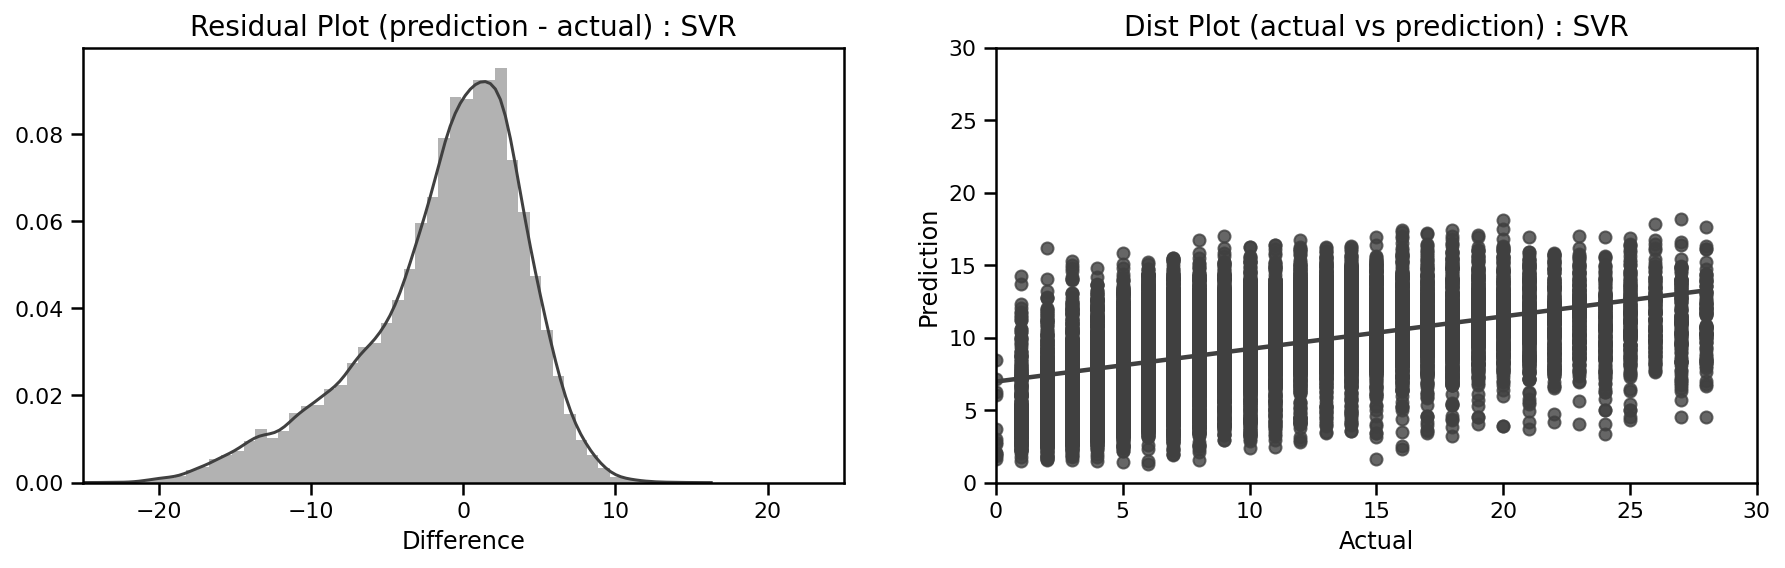

In [29]:
plot(y_test, pred,"SVR")

## $Gradient\ Boosting$
---
<p><center style="color:#159364; font-family:cursive;"><cite>Gradient Boosting in a nutshell
</cite></center></p>

<div style="text-align:center"><img src="../figure/gbm.png" /></div>

Gradient boosting is a machine learning technique for regression, classification and other tasks, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model in order to minimize the error.

## ✔️Catboost Regressor

### ✀ Feature Selection & Data Preparation
---
Since Gradient Boosting is a tree based model, feature selection can be skipped. Data Preparation is done to prepare data for catboost and lgbm format

In [31]:
catboost_df = df.copy()

In [32]:
cat_num_features =['order_quarter', 'order_is_weekend',
                               'order_approved_quarter', 'order_approved_is_weekend',
                               'pickup_limit_quarter', 'pickup_limit_is_weekend', "is_same_area"]
cat_str_features = ["order_daytime", "order_approved_daytime"]

for col in tqdm(cat_num_features):
    catboost_df[col] = catboost_df[col].astype(int)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 247.50it/s]


In [33]:
target = "wd_actual_delivery_interval"
X = catboost_df.drop([target] + ["wd_estimated_delivery_interval"], axis = 1)
y = catboost_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

train = X_train.copy()
train[target] = y_train.values
val = X_test.copy()
val[target] = y_test.values

### 📈 Build Model

In [34]:
# === Modelling Implementation (uncomment to re-train) ===
# catboost = CatBoostRegressor(objective='Poisson', loss_function = 'RMSE',eval_metric = 'RMSE', cat_features=cat_num_features + cat_str_features, iterations=10000)
# catboost.fit(X_train, y_train, eval_set = (X_test, y_test), use_best_model = True,plot = True, verbose=200, early_stopping_rounds=500)

In [35]:
# === Load Model ===
import pickle
model_file = "../bin/catboost-regressor"
with open(model_file, 'rb') as f:
    catboost = pickle.load(f)

### 🔍 Evaluation
---
> - **Root Mean Squared Log Error** (RMSLE) :
$$\sqrt{\frac{1}{N} \sum_{i=0}^{N}(\log(y_i + 1) - \log({\hat{y}}_i + 1))^2}$$

> - **Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:
$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

> All of these are **loss functions**, because we want to minimize them.

In [36]:
print("=== Evaluating Catboost Regressor Model ===")
pred = catboost.predict(X_test)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

# === Adding to Model Combine ===
# === Setting up the result dataframe (from baseline)=== 
results_catboost_df = pd.DataFrame(data=[["Catboost (GBM)", rmsle, rmse, r2]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])
results_df = results_df.append(results_catboost_df, ignore_index=True)

=== Evaluating Catboost Regressor Model ===
RMSLE: 0.1787637643423623
RMSE: 4.664363989171438
R2: 0.40297540507921314
__________________________________


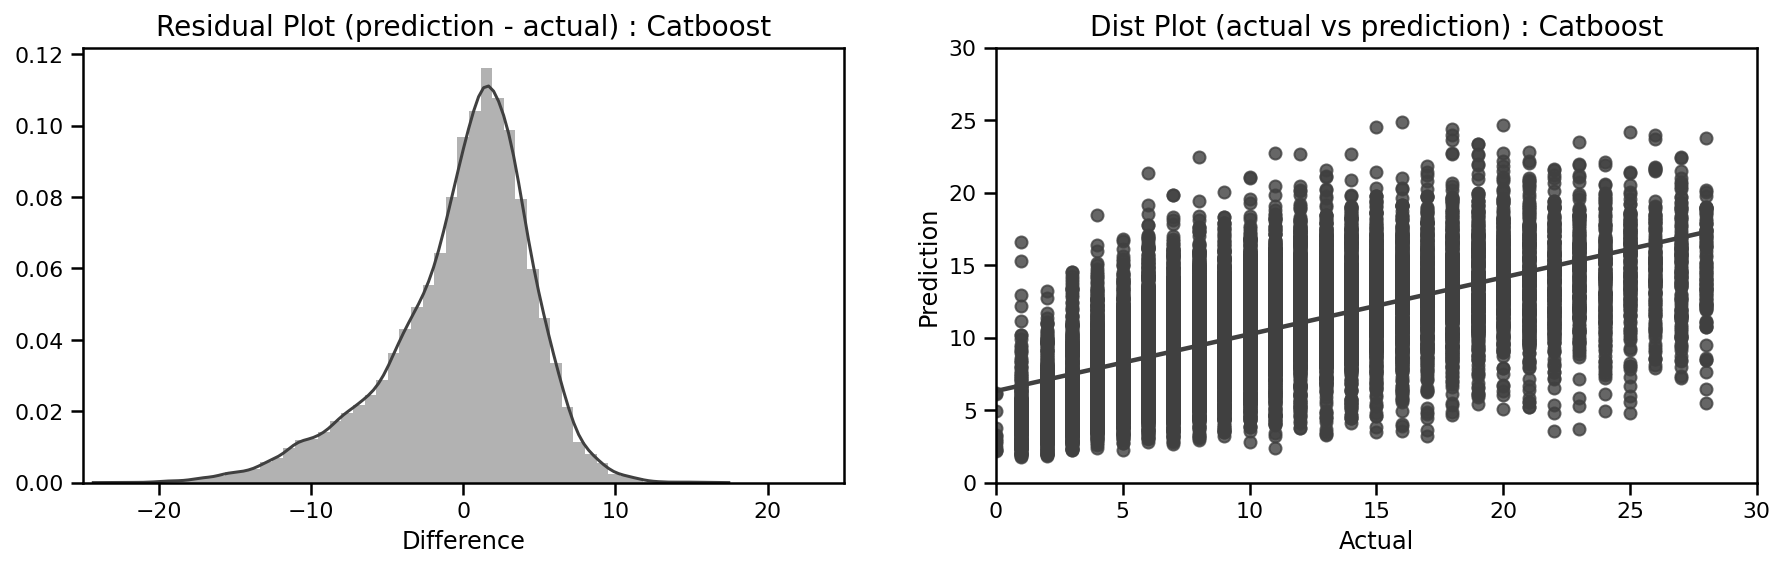

In [37]:
plot(y_test, pred,"Catboost")

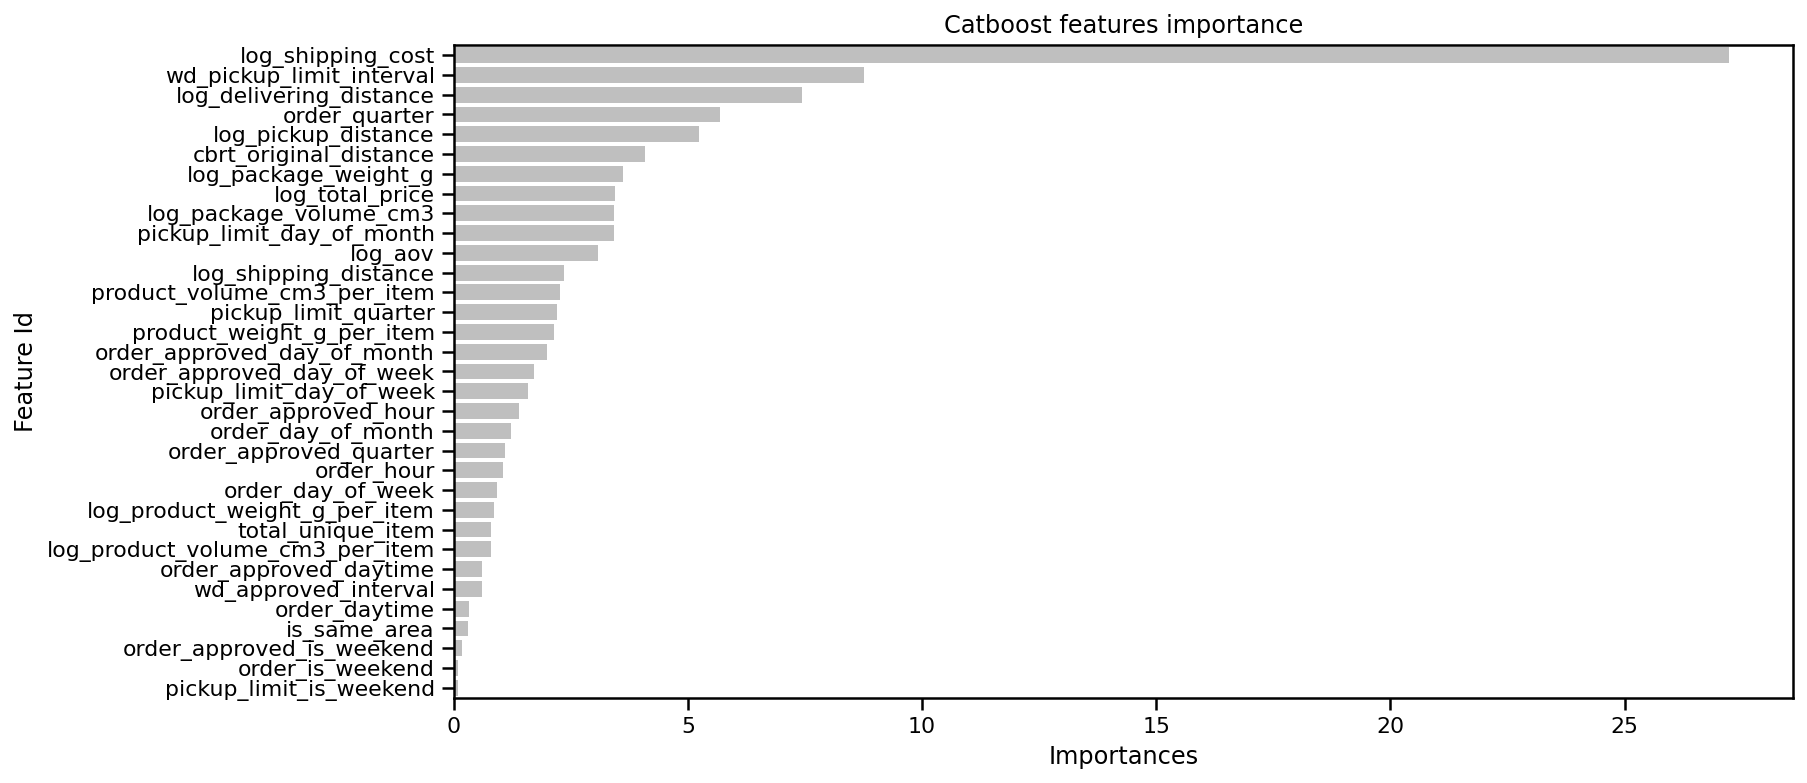

In [41]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=catboost.get_feature_importance(prettified=True), color='0.75');
plt.title('Catboost features importance')
plt.show()

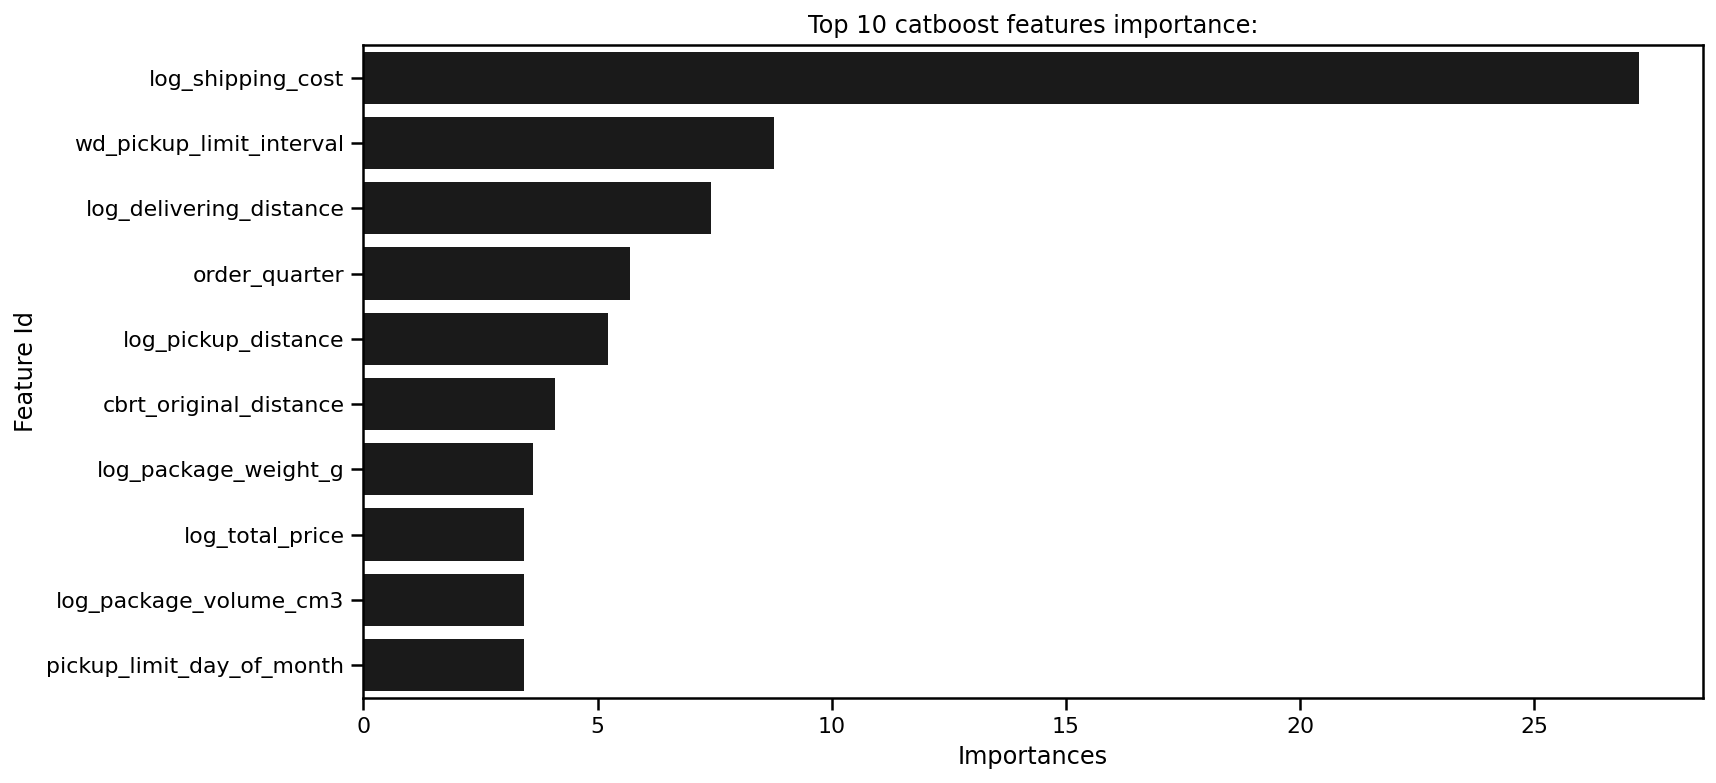

In [42]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=catboost.get_feature_importance(prettified=True)[:10], color='0.1');
plt.title('Top 10 catboost features importance:')
plt.show()

## ✔️LightGBM Regressor

### ✀ Feature Selection & Data Preparation
---
Since Gradient Boosting is a tree based model, feature selection can be skipped. Data Preparation is done to prepare data for catboost and lgbm format

In [43]:
lgbm_df = df.copy()

In [44]:
cat_num_features =['order_quarter', 'order_is_weekend',
                               'order_approved_quarter', 'order_approved_is_weekend',
                               'pickup_limit_quarter', 'pickup_limit_is_weekend', "is_same_area"]
cat_str_features = ["order_daytime", "order_approved_daytime"]

for col in tqdm(cat_num_features):
    lgbm_df[col] = lgbm_df[col].astype(int)

for col in tqdm(cat_str_features):
    enc = LabelEncoder()
    lgbm_df[col] = enc.fit_transform(df[col])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.86it/s]


In [45]:
target = "wd_actual_delivery_interval"
X = lgbm_df.drop([target] + ["wd_estimated_delivery_interval"], axis = 1)
y = lgbm_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

train = X_train.copy()
train[target] = y_train.values
val = X_test.copy()
val[target] = y_test.values

### 📈 Build Model

In [46]:
# === Modelling Implementation (uncomment to re-train) ===
# param = {
#     'learning_rate' : 0.15,
#     'random_state' : 123,
#     'n_iteration' : 1000,
# }

# fit_param = {
#     'eval_set' : (X_test, y_test),
#     'categorical_feature' :  cat_num_features + cat_str_features,
#     'verbose' : 10,
#     'early_stopping_rounds': 500,
# }
# model = LGBMRegressor(**param)
# model.fit(X_train, y_train, **fit_param)

In [47]:
# === Load Model ===
model_file = "../bin/lgbm-regressor.model"
with open(model_file, 'rb') as f:
    lgbm = pickle.load(f)

### 🔍 Evaluation
---
> - **Root Mean Squared Log Error** (RMSLE) :
$$\sqrt{\frac{1}{N} \sum_{i=0}^{N}(\log(y_i + 1) - \log({\hat{y}}_i + 1))^2}$$

> - **Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:
$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

> All of these are **loss functions**, because we want to minimize them.

In [48]:
print("=== Evaluating LGBM Regressor Model ===")
pred = lgbm.predict(X_test)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

# === Adding to Model Combine ===
# === Setting up the result dataframe (from baseline)=== 
results_lgbm_df = pd.DataFrame(data=[["LGBM", rmsle, rmse, r2]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])
results_df = results_df.append(results_lgbm_df, ignore_index=True)

=== Evaluating LGBM Regressor Model ===
RMSLE: 0.18876349336396928
RMSE: 4.761650008550699
R2: 0.3778110462511374
__________________________________


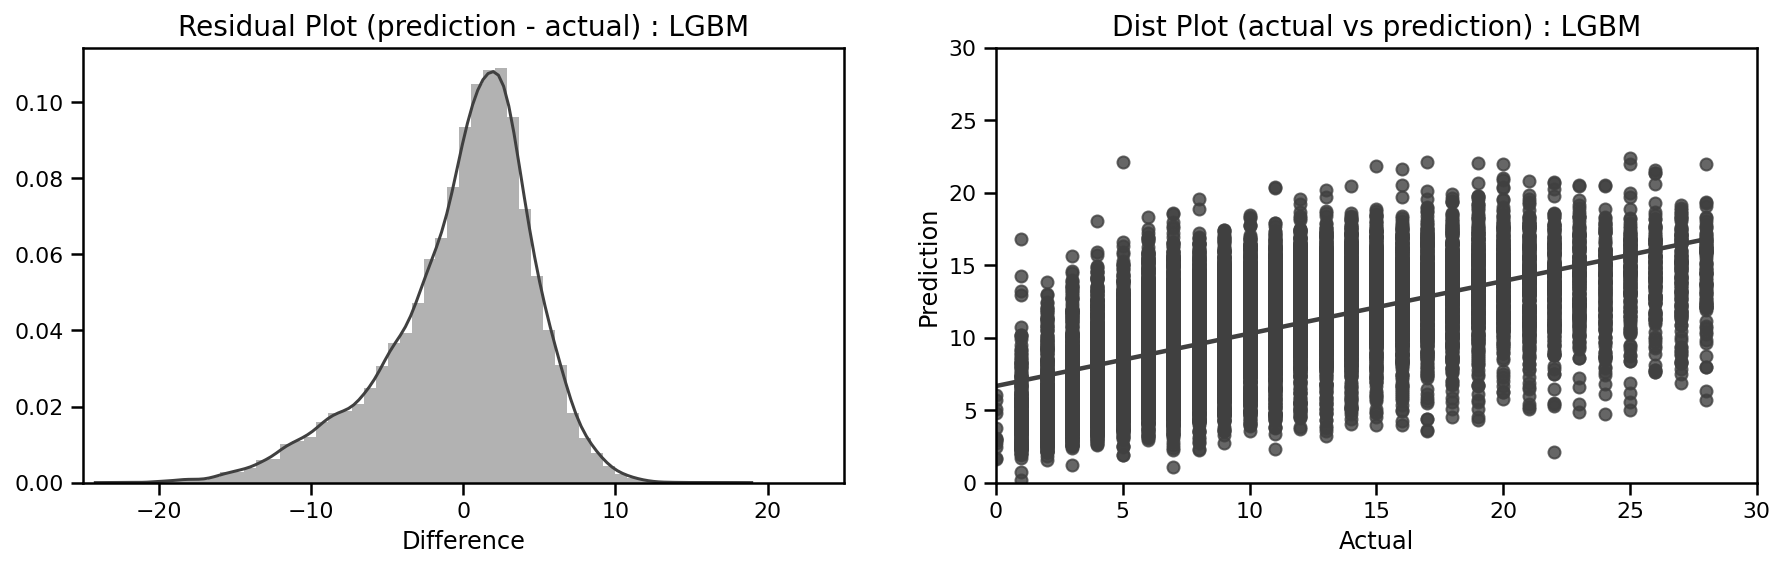

In [49]:
plot(y_test, pred,"LGBM")

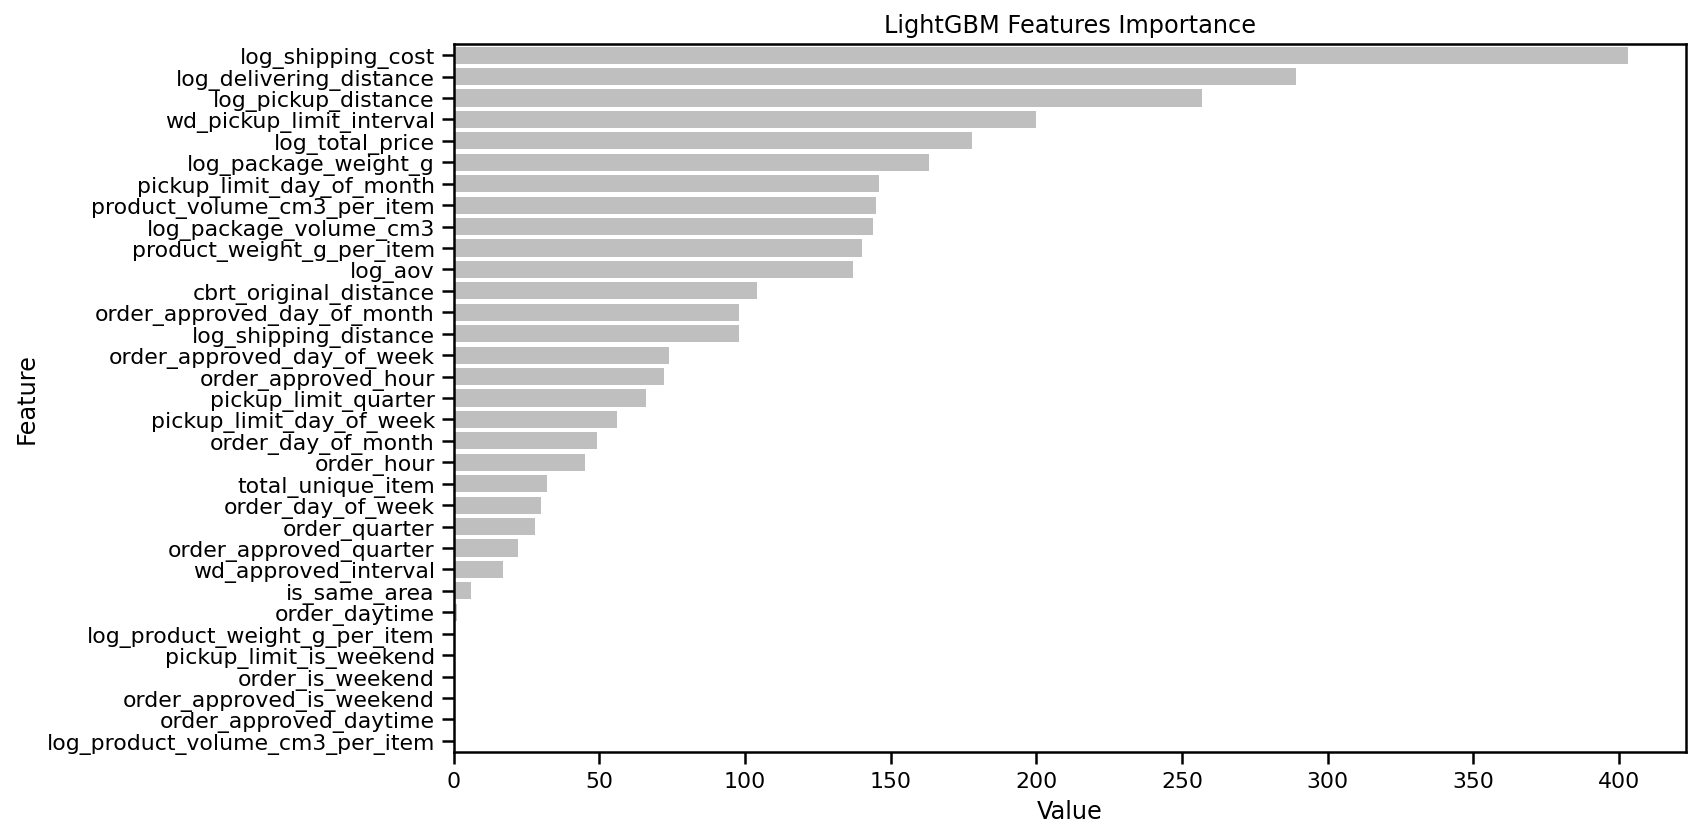

In [51]:
plt.figure(figsize=(12, 6))
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False),color='0.75')
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()

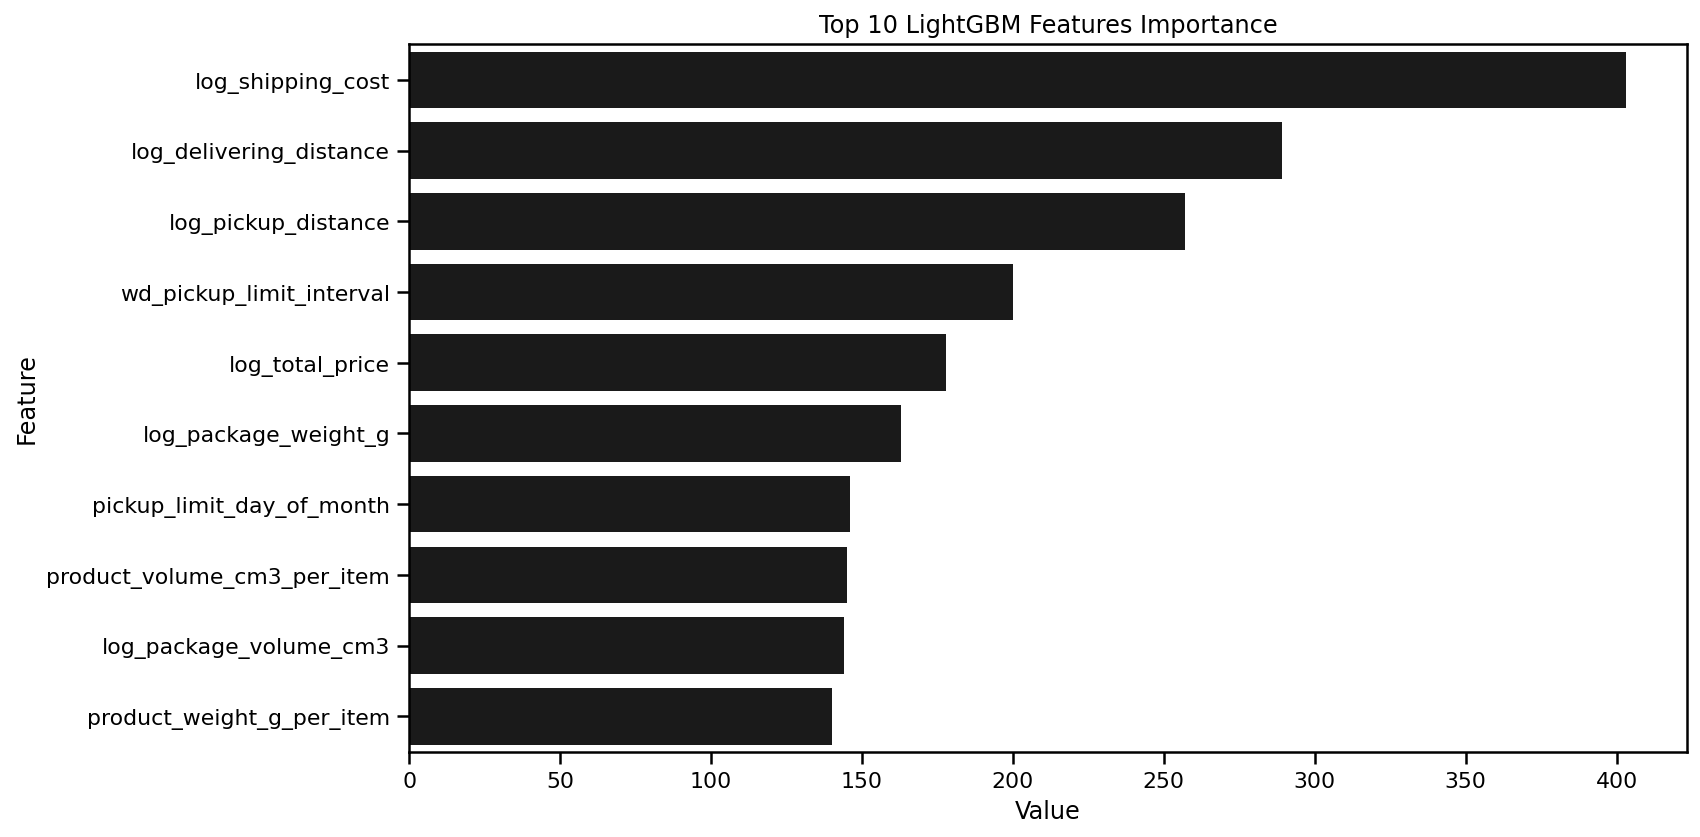

In [53]:
plt.figure(figsize=(12, 6))
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10],color='0.1')
plt.title('Top 10 LightGBM Features Importance')
plt.tight_layout()
plt.show()

In [54]:
# Show all model result -- Pick Top model
results_df.style.highlight_min(subset=['RMSLE', 'RMSE'],color='lightgreen', axis = 0).highlight_max(subset=['R2'], color = 'lightgreen', axis = 0)

,Model,RMSLE,RMSE,R2
0,Baseline (Naive),0.940213,15.229217,-5.347898
1,Linear Regression,0.320610,5.720783,0.101913
2,Poisson Regression,0.305503,5.721653,0.101640
3,Baseline (Naive),0.227132,5.441070,0.187589
4,Catboost (GBM),0.178764,4.664364,0.402975
5,LGBM,0.188763,4.761650,0.377811


Pick Catboost Regressor as **_best_** model

## ⚙️ Tuning Best Model
---

Pick best model & try to hyperparameter tuning it

In [60]:
# === Color Setup === 
baseline_color = '#F36E8E'
custom_color = '#1ABDE9'
tuned_color = light_palette[10]

## $Data\ Preparation$

**Data Loading**

In [31]:
catboost_df = df.copy()

In [32]:
cat_num_features =['order_quarter', 'order_is_weekend',
                               'order_approved_quarter', 'order_approved_is_weekend',
                               'pickup_limit_quarter', 'pickup_limit_is_weekend', "is_same_area"]
cat_str_features = ["order_daytime", "order_approved_daytime"]

for col in tqdm(cat_num_features):
    catboost_df[col] = catboost_df[col].astype(int)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 247.50it/s]


In [33]:
target = "wd_actual_delivery_interval"
X = catboost_df.drop([target] + ["wd_estimated_delivery_interval"], axis = 1)
y = catboost_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

train = X_train.copy()
train[target] = y_train.values
val = X_test.copy()
val[target] = y_test.values

## $ Modelling\ Implementation$
---
**Technique Used:**
- Custom loss function -> asymetric mse
- Custom metric func -> RMSLE (custom made)
- Using best model
- Early stopping
- Snapshot save
- Feature Importance
- Saving model

In [61]:
# === Normal Implementation (No Tuning / Baseline) ===
import pickle
model_file = f"../bin/catboost-regressor"
baseline_model = load_model(model_file)

**Custom Loss Function**

In [62]:
class AsymetricMSEObjective(object):
    """
    Penalize 10 time more for late than not late
    """
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        residual = (targets - approxes)
        der1_all = np.where(residual < 0, -2.0 * 10.0 * residual, -2.0 * residual)
        der2_all = np.where(residual < 0, 2.0 * 10.0, 2.0)
        for index in range(len(targets)):
            der1 = der1_all[index]
            der2 = der2_all[index]
            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            result.append((der1, der2))
        return result

**Custom Metric Function**

In [63]:
class RMSLEMetric(object):
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return False

    def evaluate(self, approxes, target, weight):     
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        
        approx = approxes[0]
        
        error_sum = 0.0
        weight_sum = 0.0
        
        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((log(max(0,approx[i]) + 1) - log(target[i] + 1)) ** 2)

        return error_sum, weight_sum
        
    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return np.sqrt(error / (weight + 1e-38))

In [105]:
from catboost.metrics import RMSE
# == Custom implementation (with custom loss func & metric) ==
param = {
    'eval_metric': RMSLEMetric(),
    'loss_function' : AsymetricMSEObjective(),
    'learning_rate' : 0.025,
    'use_best_model': True,
    'verbose': 20,
    'iterations' : 5000, 
    'random_state' : 123,
    'early_stopping_rounds' : 50,
    'cat_features' : cat_num_features + cat_str_features
}
    
custom_model = CatBoostRegressor(**param)

**Training**

In [106]:
custom_model.fit(
    X_train, 
    y_train, 
    eval_set = (X_test, y_test),
    use_best_model=True
)

0:	learn: 2.1322425	test: 2.1420369	best: 2.1420369 (0)	total: 1.22s	remaining: 1h 41m 36s
20:	learn: 0.8933816	test: 0.9010138	best: 0.9010138 (20)	total: 4.74s	remaining: 18m 43s
40:	learn: 0.6866445	test: 0.6934430	best: 0.6934430 (40)	total: 7.97s	remaining: 16m 3s
60:	learn: 0.6140278	test: 0.6201727	best: 0.6201727 (60)	total: 11.4s	remaining: 15m 20s
80:	learn: 0.5786814	test: 0.5844482	best: 0.5844482 (80)	total: 14.8s	remaining: 15m
100:	learn: 0.5598952	test: 0.5656199	best: 0.5656199 (100)	total: 18.2s	remaining: 14m 44s
120:	learn: 0.5485105	test: 0.5542505	best: 0.5542505 (120)	total: 21.7s	remaining: 14m 33s
140:	learn: 0.5406782	test: 0.5464036	best: 0.5464036 (140)	total: 25s	remaining: 14m 21s
160:	learn: 0.5355098	test: 0.5413548	best: 0.5413548 (160)	total: 28.5s	remaining: 14m 15s
180:	learn: 0.5315007	test: 0.5374898	best: 0.5374898 (180)	total: 31.8s	remaining: 14m 7s
200:	learn: 0.5286451	test: 0.5347459	best: 0.5347459 (200)	total: 35.3s	remaining: 14m 2s
220:	l

**Saving Model**

In [109]:
# === Saving Script ===
# save_model(custom_model, 'catboost-regressor-custom')

**Applying Result**

In [107]:
baseline_pred = baseline_model.predict(X_test)
baseline_pred = np.where(baseline_pred < 0, 0, baseline_pred)
rmsle, rmse, r2 = evaluate_model(y_test, baseline_pred)

RMSLE: 0.17876376434236232
RMSE: 4.664363989171438
R2: 0.40297540507921314
__________________________________


In [108]:
pred = custom_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

RMSLE: 0.2577473482941465
RMSE: 6.023162075241747
R2: 0.004465180603994479
__________________________________


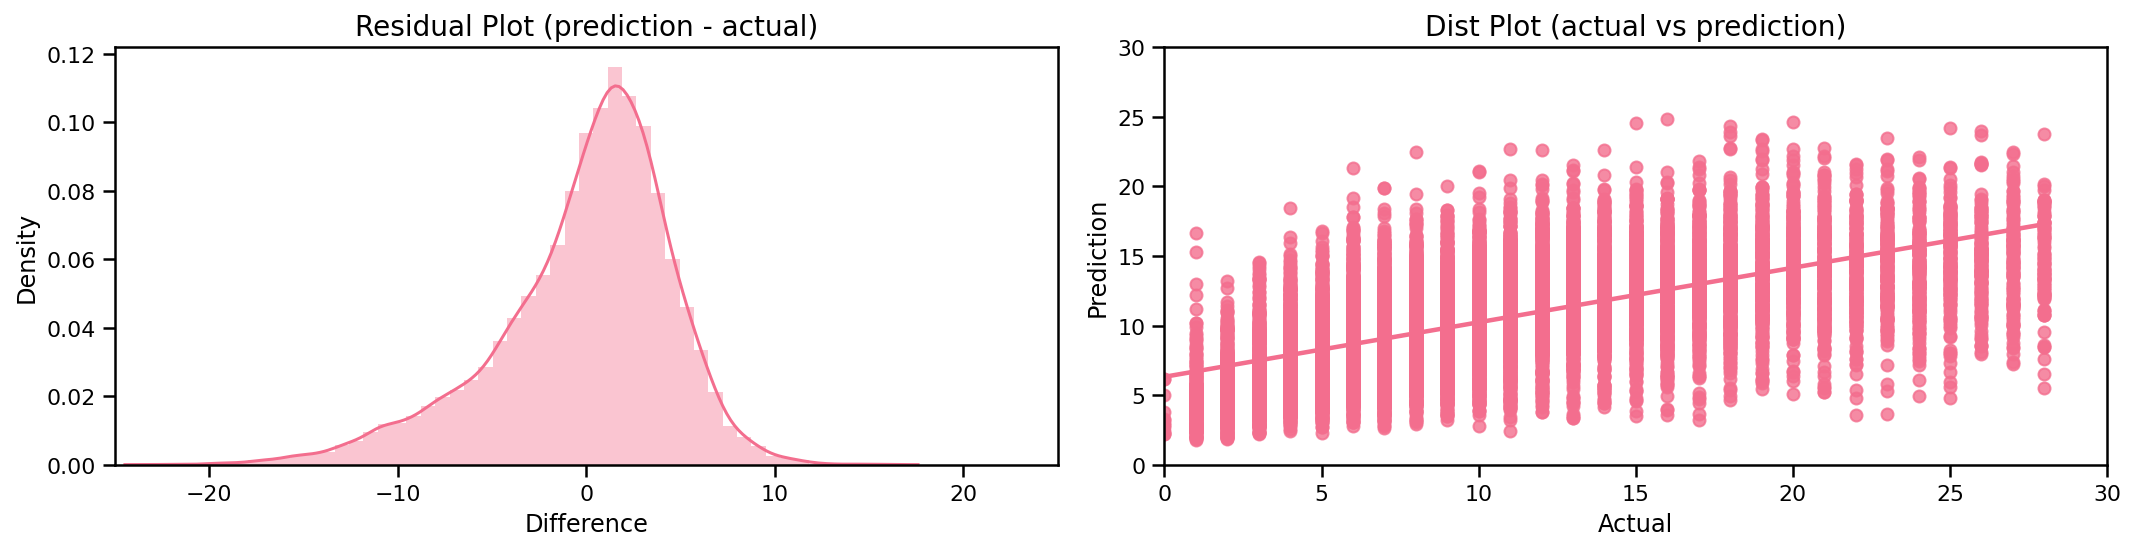

In [110]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(15,4))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : baseline_pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color = baseline_color)
a.set_xlabel("Difference",fontsize=12)
a.set_xlim(-25, 25)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color= baseline_color)
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
g.set_xlim(0,30)
g.set_ylim(0,30)
plt.plot()


plt.tight_layout()
plt.show()

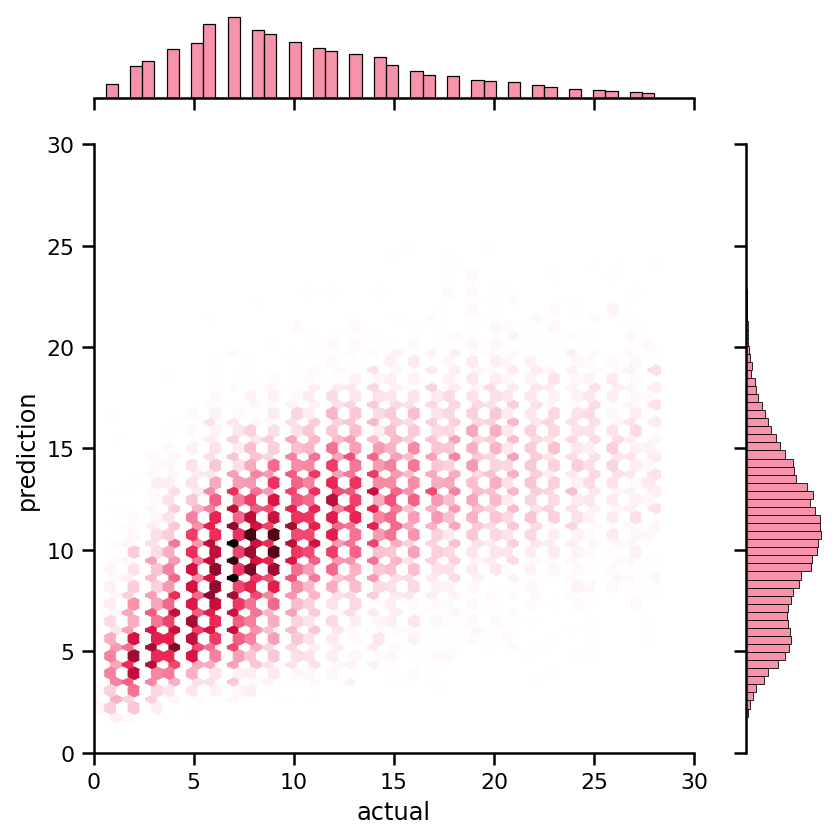

In [111]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : baseline_pred
})

g = sns.jointplot('actual', 'prediction', 
                  data=score_df,kind='hex', 
                  color=baseline_color, xlim=(0,30), ylim=(0,30))
plt.tight_layout()
plt.show()

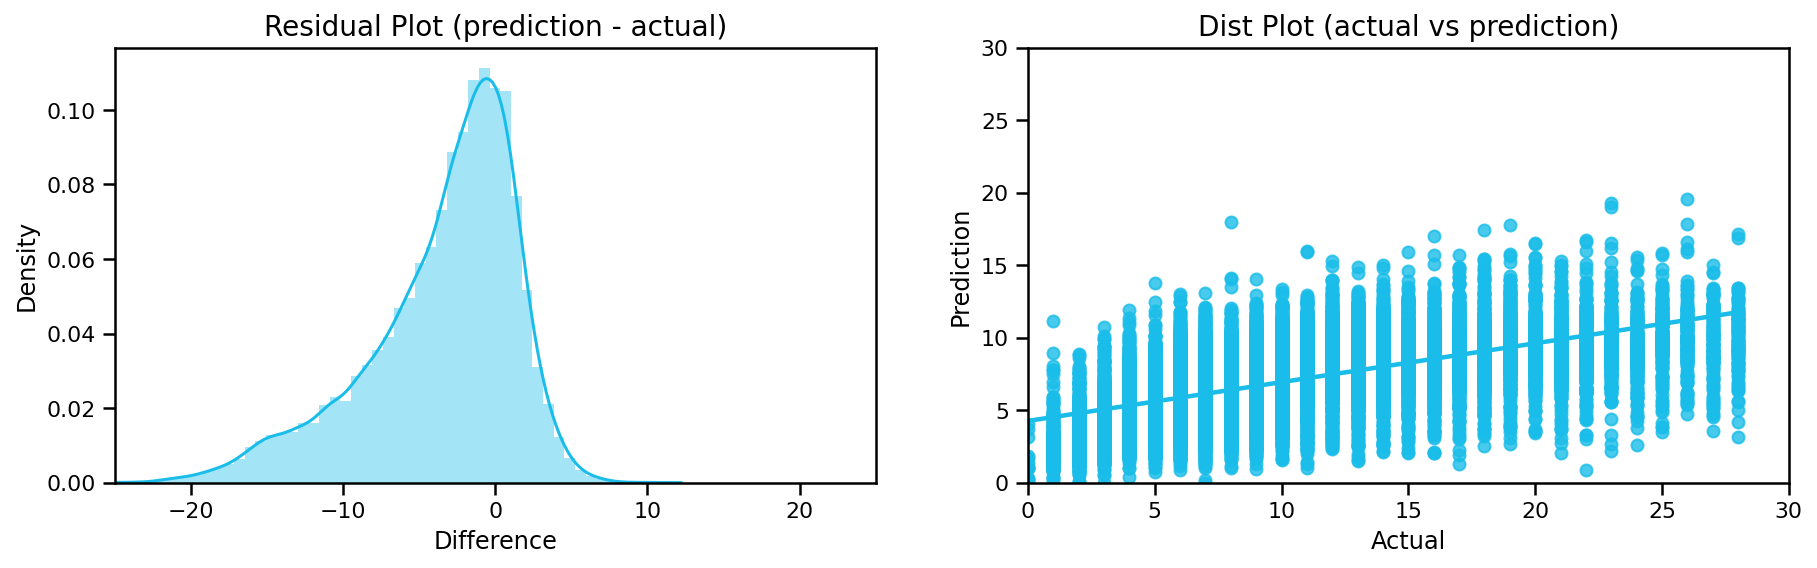

In [112]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(15,4))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color=custom_color)
a.set_xlabel("Difference",fontsize=12)
a.set_xlim(-25, 25)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color=custom_color)
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
g.set_xlim(0,30)
g.set_ylim(0,30)
plt.plot()

plt.show()

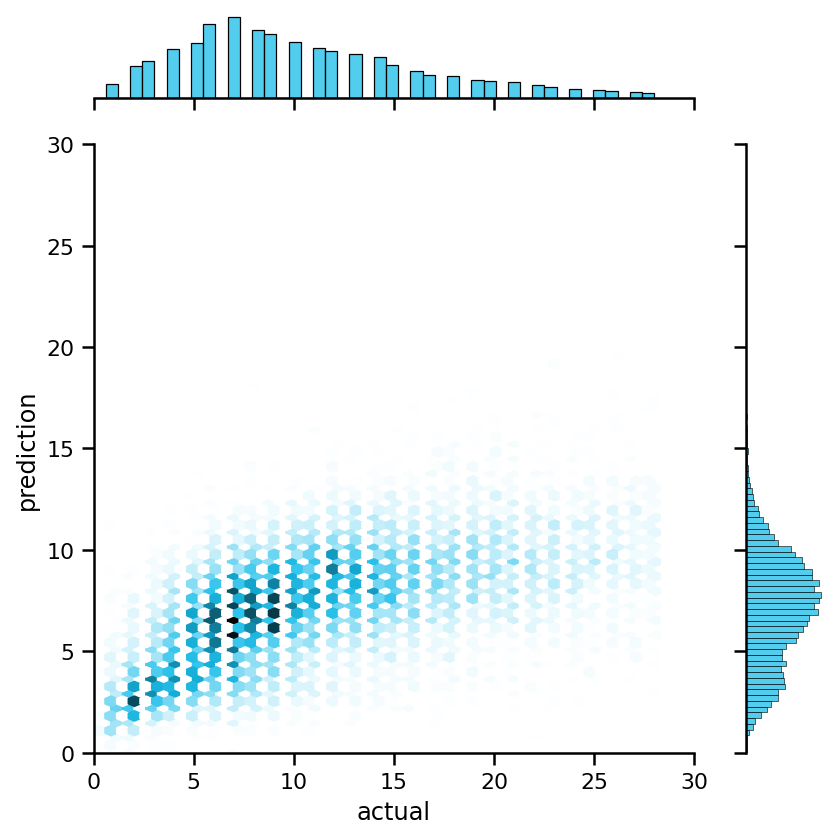

In [113]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

g = sns.jointplot('actual', 'prediction', data=score_df,
                  kind='hex', color=custom_color, space=0,
                  xlim=(0,30), ylim=(0,30))
plt.tight_layout()
plt.show()

So, our effort for creating custom loss function is not as good as we though. While that using asymetric mse is one of a good approach, currently our model with Poisson objective and RMSE evaluation metric is better than the custom one.

Also, we can see that average diff is too much to be used for end user, so this model can be used as performance indicator for shipping team, thus using RMSE as its loss func might be better because we don't need to focus on not late problem anymore

## $Hyperparameter\ Tuning$
---
Using **hyperopt** for hyperparameter tuning

**Hyperparameter** to tune (range):
- learning rate : 0.05, 0.1
- depth : 3, 5, 7
- l2_leaf_reg : 1, 3, 5, 7

In [114]:
import hyperopt

def hyperopt_objective(params):
    
    param = {
        'objective' : 'Poisson',
        'loss_function' : 'RMSE',
        'eval_metric' : 'RMSE', 
        # 'task_type' : 'GPU',
        'learning_rate' : params['learning_rate'],
        'depth':int(params['depth']),
        'l2_leaf_reg':params['l2_leaf_reg'],
        'use_best_model': True,
        'verbose': False,
        'iterations' : 10000, 
        'early_stopping_rounds' : 100,
        'cat_features' :cat_num_features + cat_str_features
    }
    
    tuned_model = CatBoostRegressor(**param)
    tuned_model.fit(
        X_train, 
        y_train, 
        eval_set = (X_test, y_test), 
        use_best_model = True
    )
        
    pred = tuned_model.predict(X_test)
    pred = np.where(pred < 0, 0, pred)
    rmsle, rmse, r2 = evaluate_model(y_test, pred)
    
    return rmsle # as hyperopt minimises

In [115]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 3, 8, 2),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'depth': hyperopt.hp.quniform('depth', 3, 7, 2),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

RMSLE:
0.18390509574385946
RMSE:
4.723627236929092
R2:
0.38770799122304145
__________________________________
RMSLE:
0.18278080799420623
RMSE:
4.730307827422388
R2:
0.3859748465316156
__________________________________
RMSLE:
0.18584622141084017
RMSE:
4.760908837598215
R2:
0.3780047238581853
__________________________________
RMSLE:
0.18274447064720192
RMSE:
4.716939104987582
R2:
0.38944063880079205
__________________________________
RMSLE:
0.1830147944722008
RMSE:
4.719059283313404
R2:
0.38889164479372984
__________________________________
RMSLE:
0.18301621171840798
RMSE:
4.705461144055817
R2:
0.39240843207133713
__________________________________
RMSLE:
0.18066386756364777
RMSE:
4.694108699935854
R2:
0.3953366588452001
__________________________________
RMSLE:
0.1828819148490538
RMSE:
4.728613051872744
R2:
0.3864147538000252
__________________________________
RMSLE:
0.18299036376654404
RMSE:
4.7185699498633475
R2:
0.38901837354956914
__________________________________
RMSLE:
0.183273

In [118]:
tuned_param = {
    'l2_leaf_reg' : int(best['l2_leaf_reg']),
    'learning_rate' : best['learning_rate'],
    'depth' : int(best['depth']),
    'objective' : 'Poisson',
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE', 
    # 'task_type' : 'GPU',
    'use_best_model': True,
    'verbose': 100,
    'iterations' : 10000,
    'early_stopping_rounds' : 100,
    'cat_features' :cat_num_features + cat_str_features
}

tuned_model = CatBoostRegressor(**tuned_param)
tuned_model.fit(
    X_train, 
    y_train, 
    eval_set = (X_test, y_test), 
    use_best_model = True
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 11.8951274	test: 11.9762766	best: 11.9762766 (0)	total: 139ms	remaining: 23m 9s
100:	learn: 10.0652399	test: 10.1416342	best: 10.1416342 (100)	total: 13.4s	remaining: 21m 55s
200:	learn: 10.0574323	test: 10.1352990	best: 10.1352990 (200)	total: 27.2s	remaining: 22m 7s
300:	learn: 10.0537464	test: 10.1328985	best: 10.1328903 (299)	total: 40.8s	remaining: 21m 53s
400:	learn: 10.0509495	test: 10.1314555	best: 10.1314555 (400)	total: 54.3s	remaining: 21m 39s
500:	learn: 10.0487813	test: 10.1302499	best: 10.1302479 (499)	total: 1m 7s	remaining: 21m 25s
600:	learn: 10.0468487	test: 10.1295596	best: 10.1295596 (600)	total: 1m 21s	remaining: 21m 10s
700:	learn: 10.0453012	test: 10.1292879	best: 10.1292855 (699)	total: 1m 34s	remaining: 20m 54s
800:	learn: 10.0436751	test: 10.1288717	best: 10.1288673 (796)	total: 1m 48s	remaining: 20m 40s
900:	learn: 10.0420788	test: 10.1284537	best: 10.1284537 (900)	total: 2m 1s	remaining: 20m 29s
1000:	learn: 10.0406011	test: 10.1280796	best: 10.128

In [119]:
# === Plot result ===
pred = tuned_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

RMSLE: 0.1785005564820028
RMSE: 4.664646464314179
R2: 0.40290309094822185
__________________________________


[]

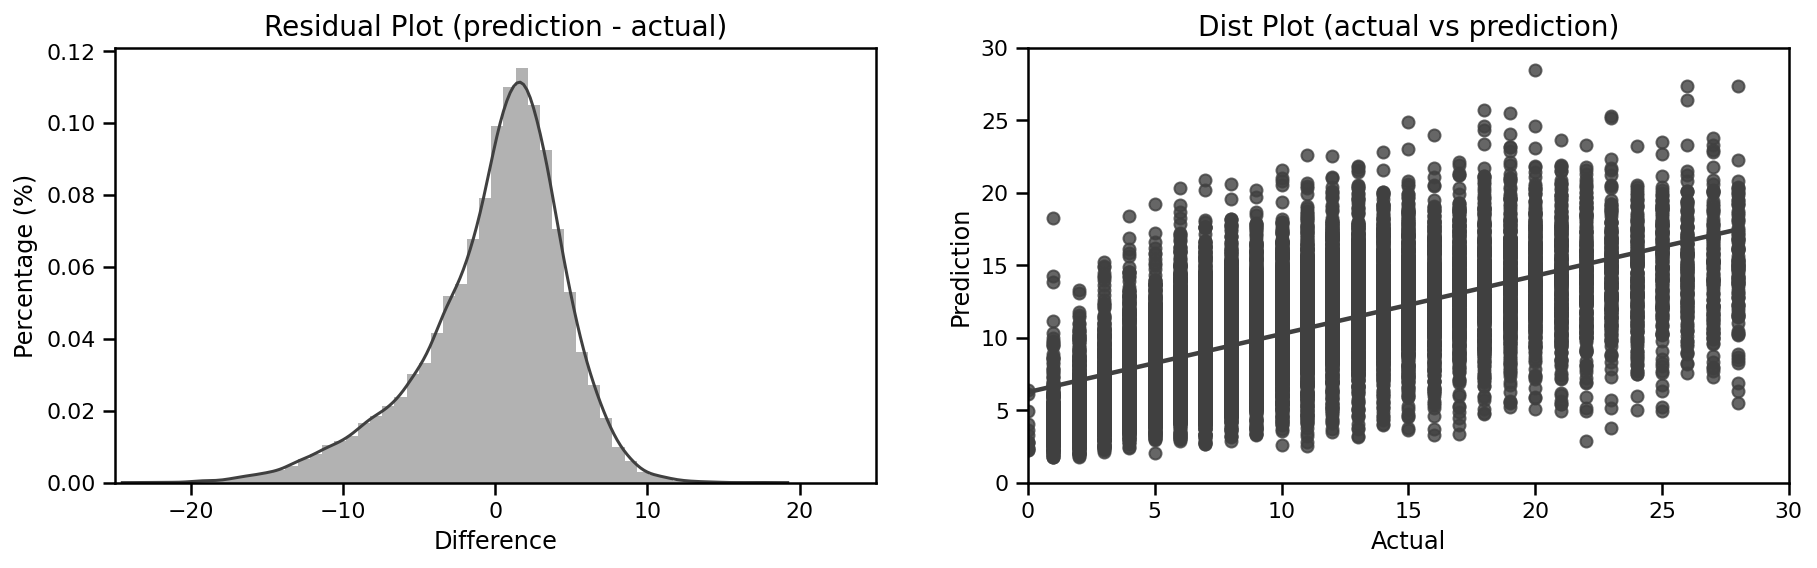

In [120]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(15,4))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color="0.25")
a.set_xlabel("Difference",fontsize=12)
a.set_ylabel("Percentage (%)",fontsize=12)
a.set_xlim(-25, 25)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color="0.25")
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
g.set_xlim(0,30)
g.set_ylim(0,30)
plt.plot()

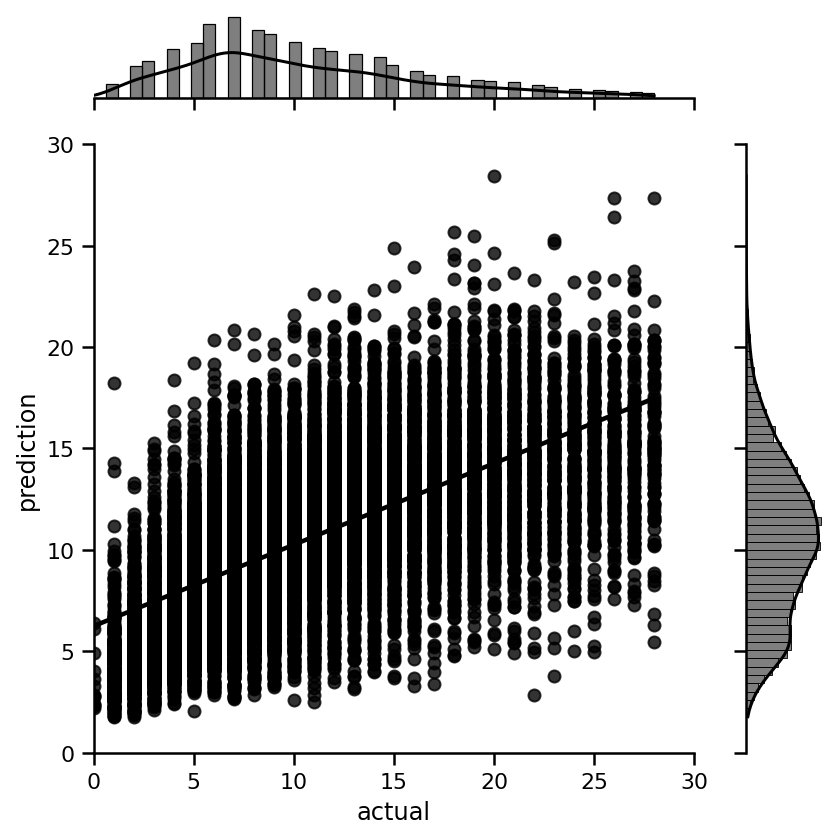

In [121]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

g = sns.jointplot('actual', 'prediction', data=score_df,
                  kind='reg', color=tuned_color, space=0,
                  xlim=(0,30), ylim=(0,30),)
plt.tight_layout()
plt.show()

In [122]:
# == Save Model ==
# save_model(tuned_model, 'catboost-regressor-tuned')

In [64]:
# == Load all model ==
rmsle_score = []; rmse_score=[]; r2_score = []
baseline_model = load_model(f'../bin/catboost-regressor')
custom_model = load_model(f'../bin/catboost-regressor-custom')
tuned_model = load_model(f'../bin/catboost-regressor-tuned')

print("===Baseline===")
pred = baseline_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

print("===Custom Loss===")
pred = custom_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

print("===Tuned===")
pred = tuned_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

===Baseline===
RMSLE: 0.1843512924306632
RMSE: 5.087694093149437
R2: 0.2896876978077164
__________________________________
===Custom Loss===
RMSLE: 0.24410545231366673
RMSE: 5.853194472297102
R2: 0.05985841599717856
__________________________________
===Tuned===
RMSLE: 0.17464028494698652
RMSE: 4.78664630547982
R2: 0.3712615346134819
__________________________________


In [65]:
# === versus (all model type) ===
results_df = pd.DataFrame(data=[["Baseline", rmsle_score[0], rmse_score[0], r2_score[0]], 
                                ['Custom', rmsle_score[1], rmse_score[1], r2_score[1]], 
                                ['Tuned', rmsle_score[2], rmse_score[2], r2_score[2]]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])
results_df.style.highlight_min(subset=['RMSLE', 'RMSE'],color='lightgreen', axis = 0).highlight_max(subset=['R2'], color = 'lightgreen', axis = 0)

,Model,RMSLE,RMSE,R2
0,Baseline,0.184351,5.087694,0.289688
1,Custom,0.244105,5.853194,0.059858
2,Tuned,0.174640,4.786646,0.371262


**Cross Validation**

ps: Because training took too long, only using tuned model to train the result

In [66]:
# === Create a cross validation scoring ===
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=123)
scores_rmse = []
scores_rmsle = []
scores_r2 = []
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"=== Fold {idx+1} ===")
    X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    pred_fold = tuned_model.predict(X_test_fold)
    pred_fold = np.where(pred_fold < 0, 0, pred_fold)
    rmsle, rmse, r2  = evaluate_model(y_test_fold,pred_fold)
    
    scores_rmse.append(rmse)
    scores_rmsle.append(rmsle)
    scores_r2.append(r2)
print("Precise RMSLE score :", np.min(scores_rmsle))
print("Precise RMSE score :", np.min(scores_rmse))

=== Fold 1 ===
RMSLE: 0.17464028494698655
RMSE: 4.78664630547982
R2: 0.371261534613482
__________________________________
=== Fold 2 ===
RMSLE: 0.14813448773332621
RMSE: 4.297457849401861
R2: 0.49420355250601533
__________________________________
=== Fold 3 ===
RMSLE: 0.14680009678134454
RMSE: 4.343538321243529
R2: 0.484773726864442
__________________________________
=== Fold 4 ===
RMSLE: 0.14481758527239527
RMSE: 4.306097784478707
R2: 0.4938604521956983
__________________________________
=== Fold 5 ===
RMSLE: 0.14655964987430561
RMSE: 4.312467197878357
R2: 0.49000015061948643
__________________________________
Precise RMSLE score : 0.14481758527239527
Precise RMSE score : 4.297457849401861


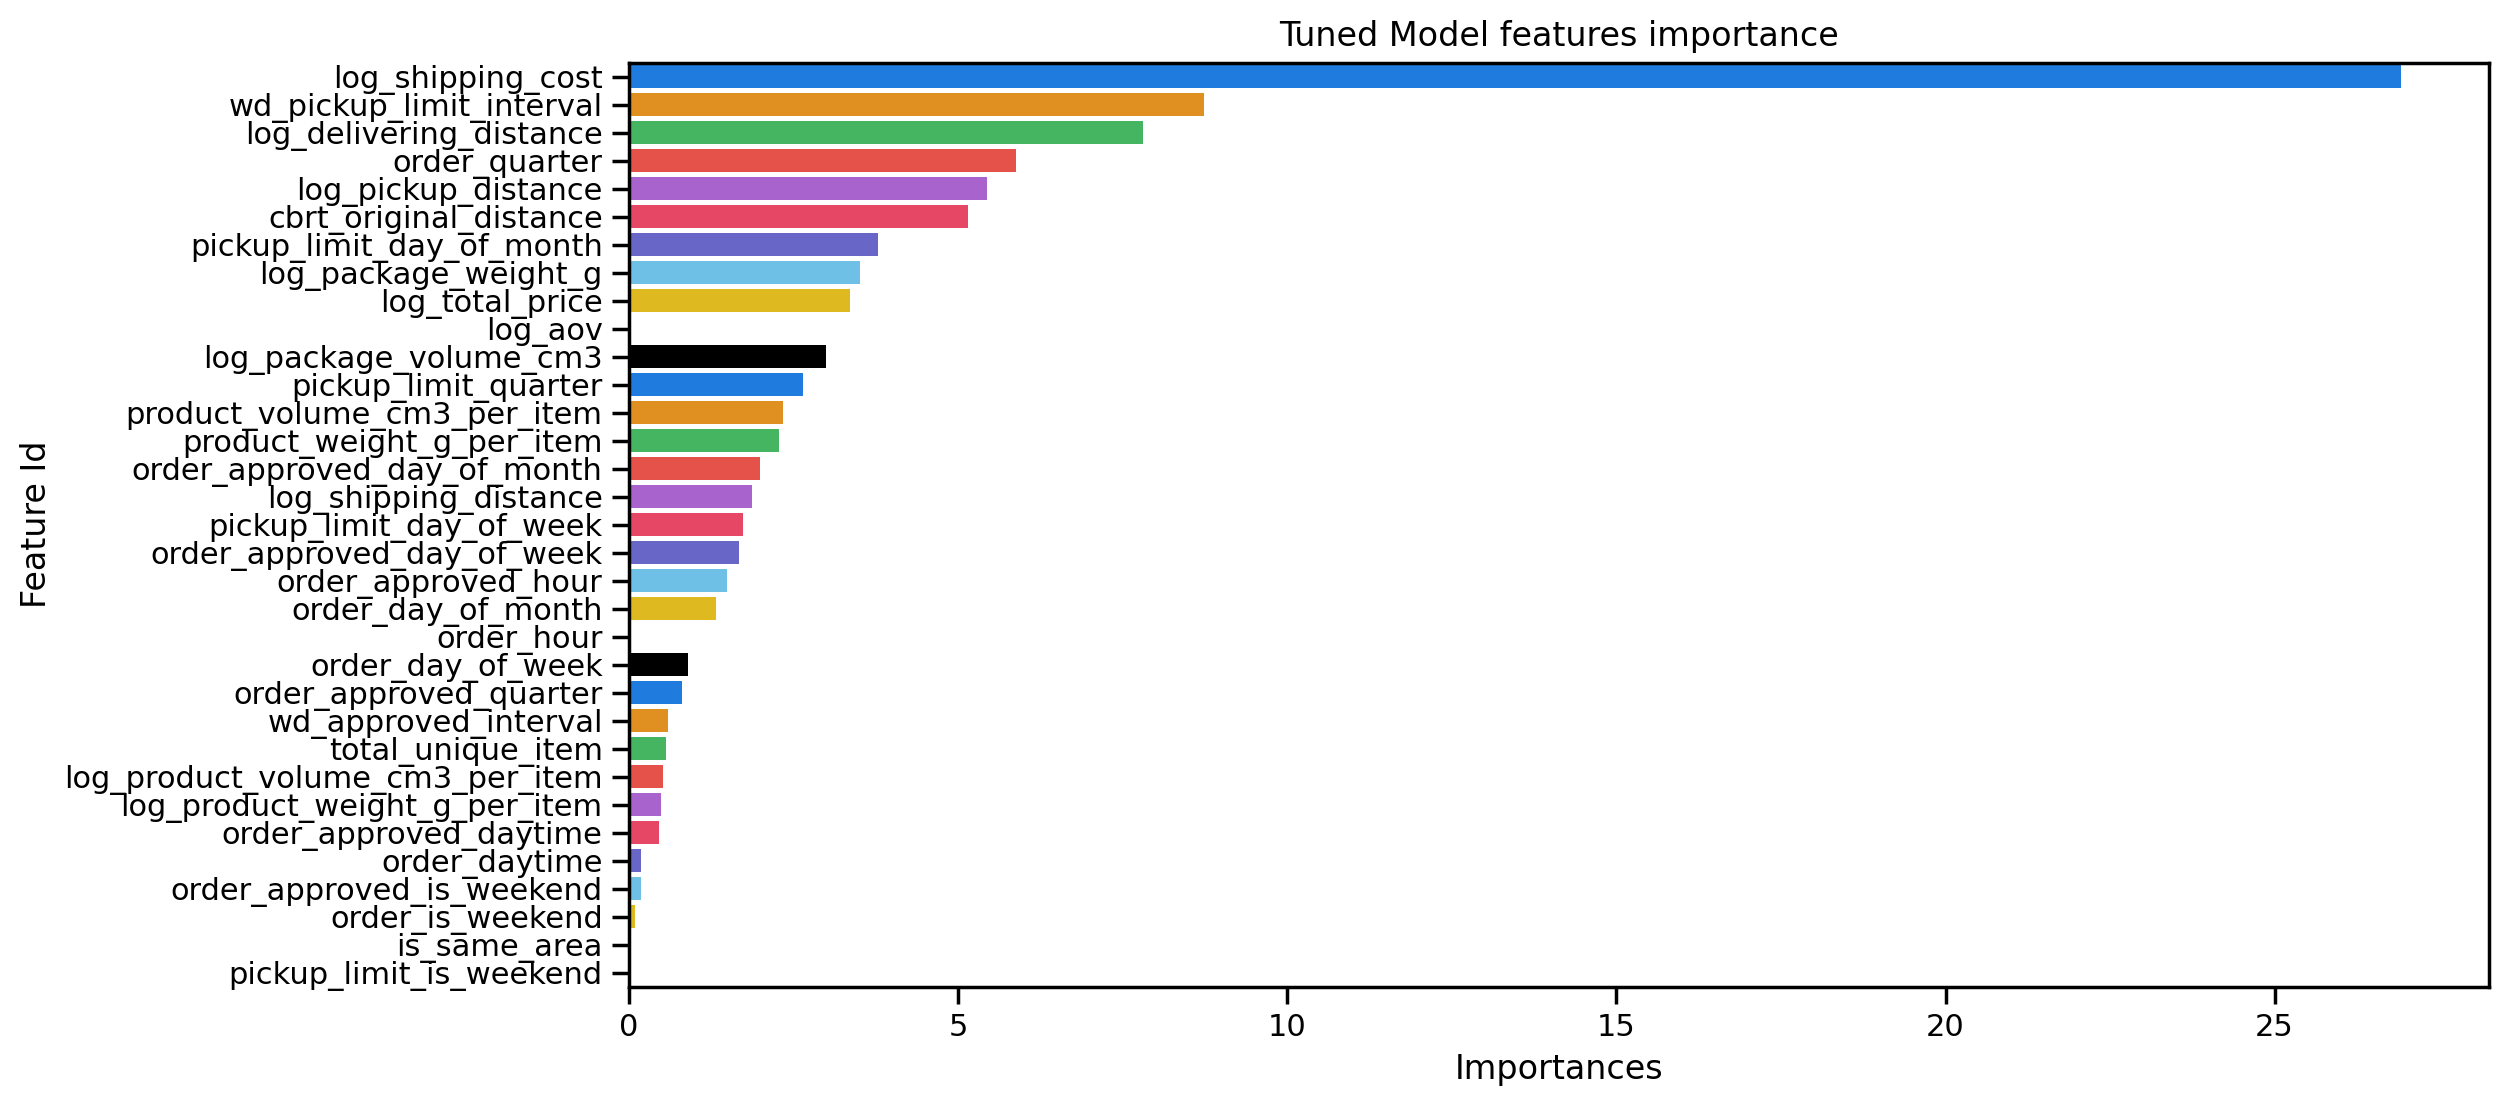

In [67]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=tuned_model.get_feature_importance(prettified=True), palette=light_palette);
plt.title('Tuned Model features importance')
plt.show()

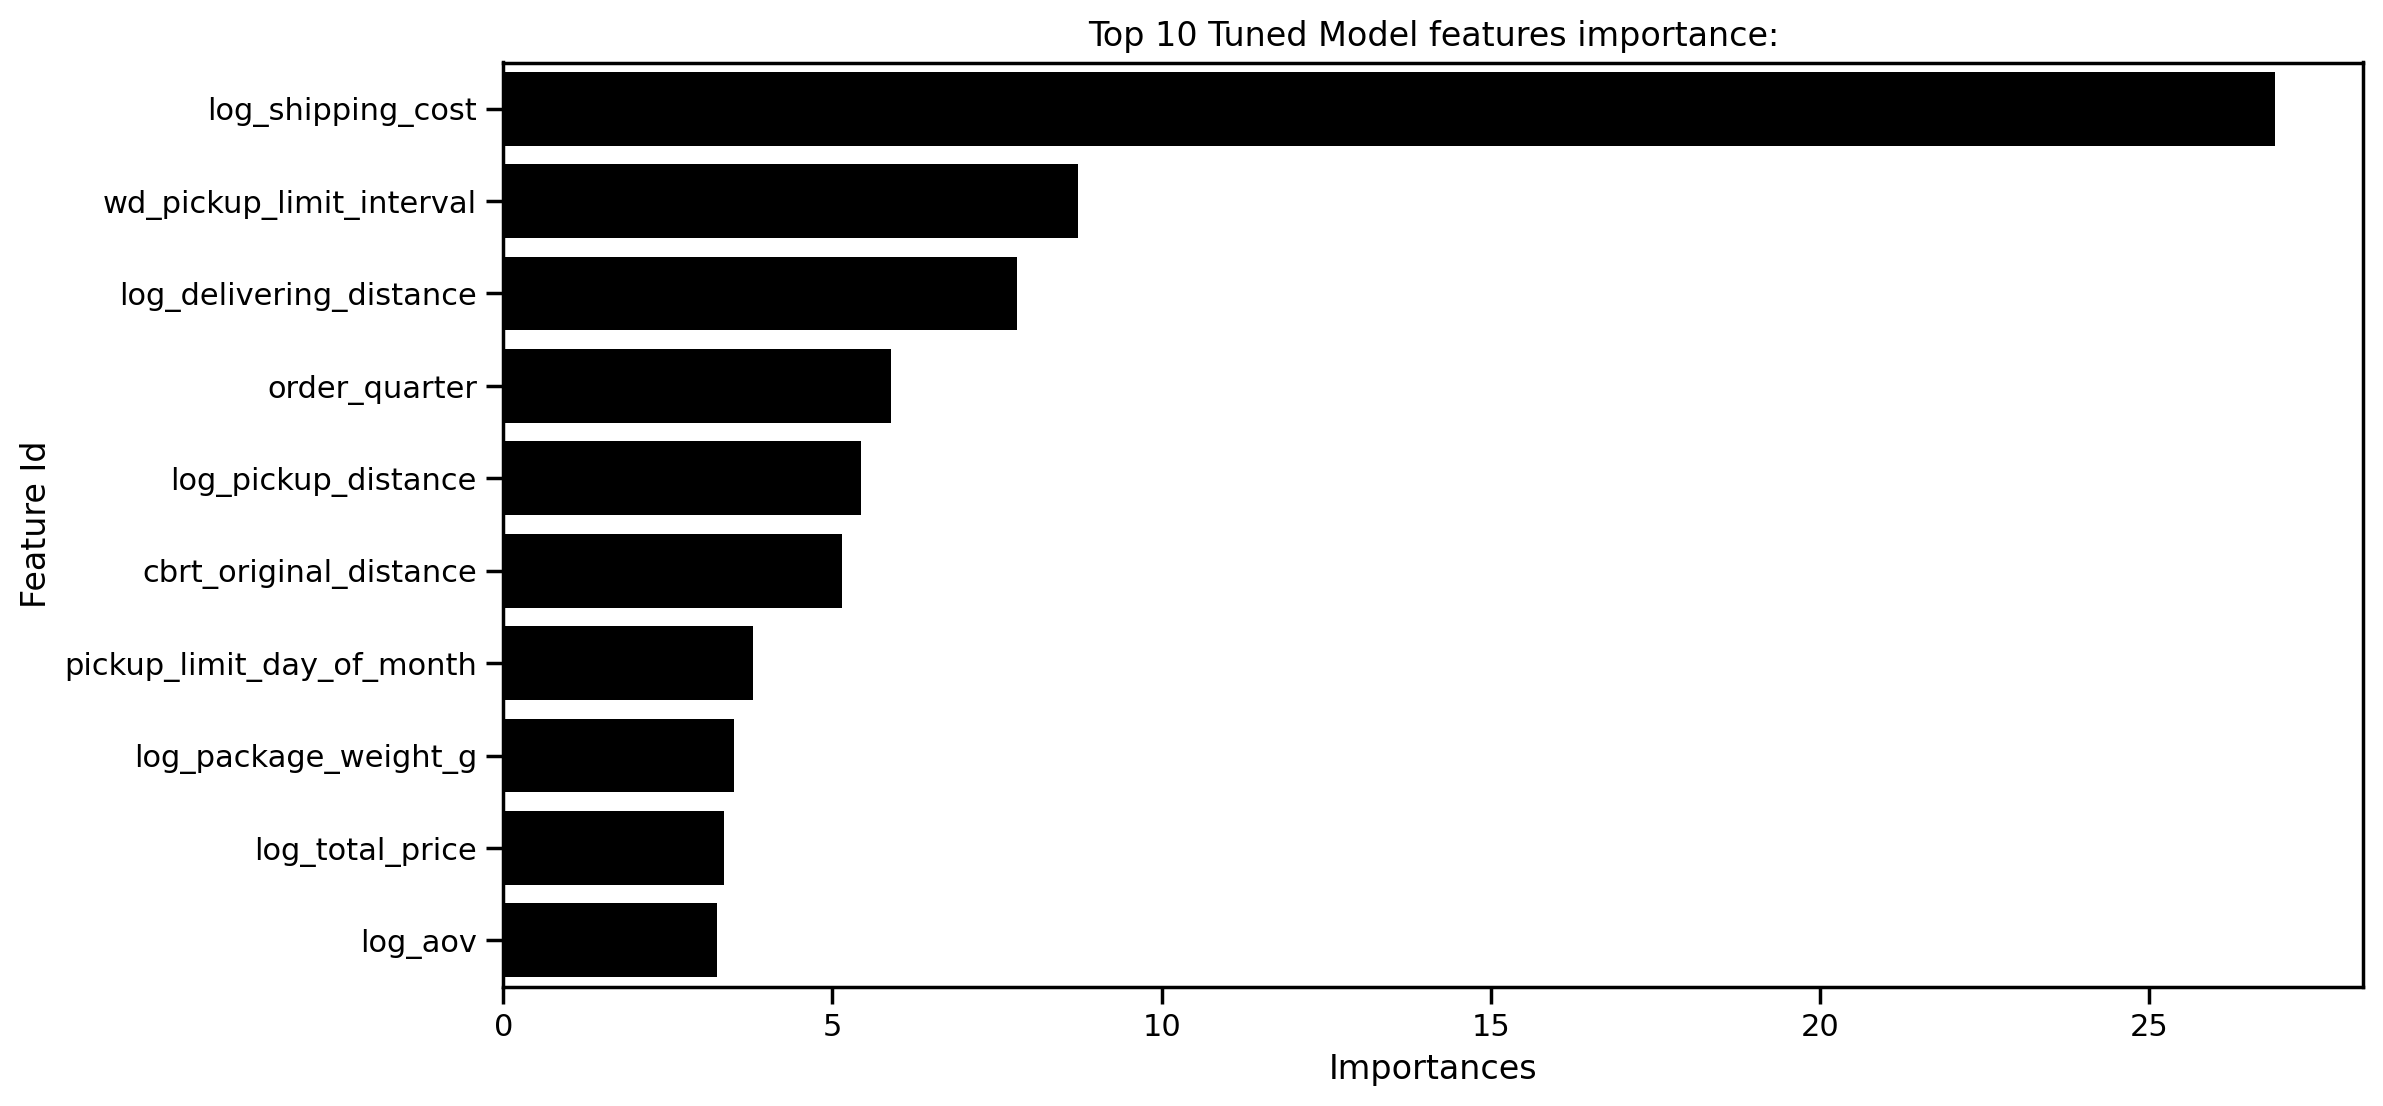

In [68]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=tuned_model.get_feature_importance(prettified=True)[:10], color=light_palette[10]);
plt.title('Top 10 Tuned Model features importance:')
plt.show()

**Tuning END**

<h2 style="font-family:verdana;"> <center>🔥 Thanks for seeing my notebook till the end ✨</center> </h2>

**Reference :**
- [Linear Model](https://www.kaggle.com/faressayah/linear-regression-house-price-prediction)
- [SVM](https://www.kaggle.com/azzion/svm-for-beginners-tutorial)
- [Gradient Boosting](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting)
- [Still confused with Gradient Boosting?](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)
- [Hyperparameter Tuning]()